In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LinearRegression as LinReg
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso as Lasso_Reg
import sys
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import math
%matplotlib inline

We first read in data for non-meat food group consumption rates by country. As the data downloaded from the the World Health Organization's Global Health Observatory Data Repository (WHO) has many elements (e.g. "Item Code") which we don't need, we first "wash" the data to get non-meat food group consumption rates (kgs per capita) for each country. For this particular case, we look at non-meat food group consumption rates in the year 2000, though (as we will implement later on) we can get food consumption rates for a range of years.

In [2]:
agridata=pd.read_csv('data/FoodSupply_Crops_E_All_Data.csv')
# prepare to clean data
agricountries=[]
agri=sorted(list(set(agridata['Item'])),key=str.lower)
year='Y2000'
X=[]
observation=list(np.zeros(len(agri)))
# iterate through 'units' column
for i in agridata.index:
    # if appropriate unit found, begin appending data
    if agridata['Element'].iloc[i] == 'Food supply quantity (kg/capita/yr)':
        # if we haven't seen this country
        if agridata['Country'].iloc[i] not in agricountries:
            if i > 4:
                # we found a new country and can record the current observation
                X.append(observation)
            # and start recording a new country's data 
            agricountries.append(agridata['Country'].iloc[i])
            observation=list(np.zeros(len(agri)))
        # find appropriate column for food consumption value
        k=agri.index(agridata['Item'].iloc[i])
        # append country's consumption of food (kg/capita/yr) to observation list for given year      
        observation[k]=agridata[year].iloc[i]
# append last observation
X.append(observation)
washed=pd.DataFrame(data=np.array(X),index=agricountries,columns=agri)
washed.head()

,Alcoholic Beverages,Apples and products,Bananas,Barley and products,Beans,Beer,"Beverages, Alcoholic","Beverages, Fermented",Cassava and products,Cereals - Excluding Beer,...,Tea (including mate),Tomatoes and products,Treenuts,Vegetable Oils,Vegetables,"Vegetables, Other",Vegetal Products,Wheat and products,Wine,Yams
Afghanistan,0.00,0.40,0.03,4.06,0.00,0.00,0.00,0.00,0.00,152.56,...,0.94,0.00,0.64,1.99,29.34,29.34,0.0,126.26,0.00,0.0
Albania,15.73,10.94,5.40,0.15,4.84,12.49,0.93,0.01,0.00,172.77,...,0.06,43.71,2.42,6.96,156.73,102.24,0.0,161.61,2.37,0.0
Algeria,3.17,2.89,0.00,9.19,1.11,3.16,0.00,0.00,0.00,209.26,...,0.19,23.93,0.89,15.02,75.82,42.43,0.0,180.20,0.01,0.0
Angola,15.94,0.21,18.31,0.00,7.07,8.73,0.50,4.93,194.80,73.55,...,0.03,3.28,0.08,8.05,20.05,16.35,0.0,26.04,1.78,0.0
Antigua and Barbuda,25.64,0.00,19.50,0.00,1.78,10.26,5.74,0.00,0.64,76.92,...,0.44,3.54,0.00,0.00,51.28,50.41,0.0,62.68,6.54,0.5


We now follow the same procedure to get meat product consumption rates by country (kgs per capita) for the year 2000. We combine these two dataframes to get a "dinner" dataframe with all our data.

In [3]:
meatdata=pd.read_csv('data/FoodSupply_LivestockFish_E_All_Data.csv')
# prepare to clean data
meatcountries=[]
meat=sorted(list(set(meatdata['Item'])),key=str.lower)
year='Y2000'
X=[]
observation=list(np.zeros(len(agri)))
# iterate through 'units' column
for i in meatdata.index:
    # if appropriate unit found, begin appending data
    if meatdata['Element'].iloc[i] == 'Food supply quantity (kg/capita/yr)':
        # if we haven't seen this country
        if meatdata['Country'].iloc[i] not in meatcountries:
            if i > 4:
                # we found a new country and can record the current observation
                X.append(observation)
            # and start recording a new country's data 
            meatcountries.append(meatdata['Country'].iloc[i])
            observation=list(np.zeros(len(meat)))
        # find appropriate column for food consumption value
        k=meat.index(meatdata['Item'].iloc[i])
        # append country's consumption of food (kg/capita/yr) to observation list for given year      
        observation[k]=meatdata[year].iloc[i]
# append last observation
X.append(observation)
cooked=pd.DataFrame(data=np.array(X),index=meatcountries,columns=meat)

dinner=pd.concat([washed,cooked], axis=1, join='inner')
dinner.head()

,Alcoholic Beverages,Apples and products,Bananas,Barley and products,Beans,Beer,"Beverages, Alcoholic","Beverages, Fermented",Cassava and products,Cereals - Excluding Beer,...,Milk - Excluding Butter,"Milk, Whole","Molluscs, Other",Mutton & Goat Meat,Offals,"Offals, Edible",Pelagic Fish,Pigmeat,Poultry Meat,Whey
Afghanistan,0.00,0.40,0.03,4.06,0.00,0.00,0.00,0.00,0.00,152.56,...,73.23,41.14,0.00,8.24,2.42,2.42,0.00,0.00,0.64,0.00
Albania,15.73,10.94,5.40,0.15,4.84,12.49,0.93,0.01,0.00,172.77,...,246.29,216.51,0.33,5.99,3.93,3.84,1.70,4.15,5.34,0.00
Algeria,3.17,2.89,0.00,9.19,1.11,3.16,0.00,0.00,0.00,209.26,...,103.00,67.64,0.00,5.75,1.23,1.23,3.03,0.00,7.70,0.13
Angola,15.94,0.21,18.31,0.00,7.07,8.73,0.50,4.93,194.80,73.55,...,14.79,12.66,0.00,0.79,1.27,1.27,6.73,2.93,3.95,0.00
Antigua and Barbuda,25.64,0.00,19.50,0.00,1.78,10.26,5.74,0.00,0.64,76.92,...,128.21,107.92,8.78,2.53,0.00,1.37,6.19,7.33,49.87,0.00


We now initialize dataframes from reading in data on diabetes and cardiovascular disease mortality rates per 100000 people by country obtained from WHO. (We have data for the years 2000 and 2012 for males, females, and both sexes).

In [4]:
# Read in disease data 
diabdata = pd.read_csv('data/DiabetesDeathRate.csv', skiprows=2)
cardiodata = pd.read_csv('data/CardioDeathRate.csv', skiprows=2)

Diabetes and Cardio Disease mortality rates were collected from reported deaths in the corresponding countries and averaged per 100,000 citizens in the population. We now generate a heatmap which shows the correlation between food group consumption rate values for all 127 food groups in our dataframe. White rows or columns indicate food groups on which we have insufficient data (i.e. "NaN" cell values). We may think about using a k-nearest neighbors approach to determine food group consumption for countries where we don't have data by looking at the consumption rates for that food group in neighboring countries. Red cells indicate close correlation in consumption rates between two food groups. Axes indicate food group indices, i.e. position 60 on either axis indicates the food group corresponding to the 60th column in our "master" dataframe containing all of the food group consumption rates for each country.

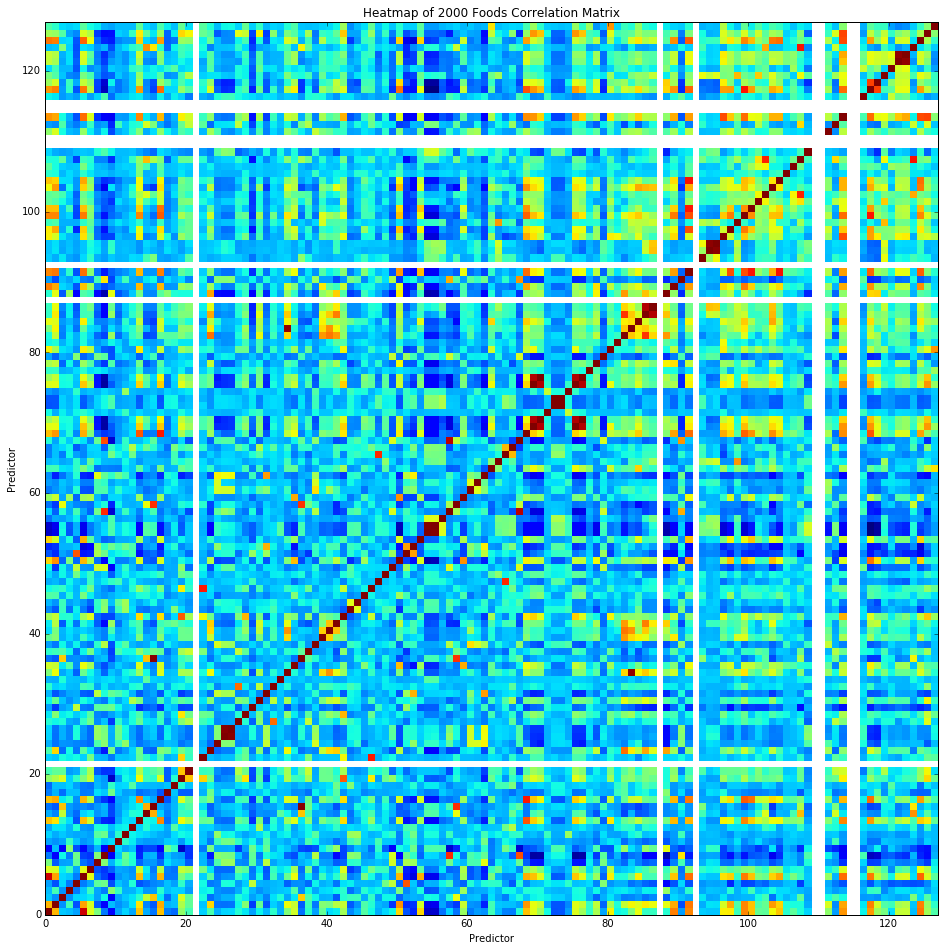

In [5]:
# function to heatmap correlation matrix
def heatplotter(ax,panda):
    # Compute matrix of correlation coefficients
    corr_matrix = panda.corr()
    # Display heat map 
    Zm = ma.masked_where(np.isnan(corr_matrix),corr_matrix)
    ax.pcolormesh(Zm)        
    # Format graph
    if panda.equals(cooked): 
        ax.set_title('Heatmap of 2000 Meats Correlation Matrix')
    elif panda.equals(washed):
        ax.set_title('Heatmap of 2000 Crops Correlation Matrix')
    elif panda.equals(dinner):
        ax.set_title('Heatmap of 2000 Foods Correlation Matrix')
    ax.set_xlabel('Predictor')
    ax.set_ylabel('Predictor')
    ax.set_ylim([0,len(panda.columns.values)])
    ax.set_xlim([0,len(panda.columns.values)])
    return ax

# Plot correlation matrices of agriculural and livestock data
fig, ax1 = plt.subplots(1, 1, figsize=(16, 16))
ax1=heatplotter(ax1,dinner)
plt.show()

Some rows / columns in the heat map show up as white. When we go into the dataframe, we see that these are food groups whose recorded values are 0.0 for all countries. We thus write a function to remove these food groups from our dataframe to avoid erroneous results when creating a model. We also create a list of the food groups in our dataframe and a separate list of the countries in our dataframe.

In [6]:
# Investigate and remove food groups for which we have no data, returning the new dataframe and a list of the 
# food groups that were removed
def removeMissing(df):
    if "Grand Total" in df.columns.values.tolist():
        del df["Grand Total"]
    new = df.copy()
    foodGroups = list(df.columns.values)
    # Duplicate columns in the dataframe whose values are all 0.0 and can be removed in advance
    removed = ["Grand Total"]
    for foodGroup in foodGroups:
        # Check if all values in food group column are 0.0
        if len(df[df[foodGroup] == 0.0]) == len(df[foodGroup]):
            del new[foodGroup]
            removed.append(foodGroup)
    return new, removed
del dinner["Grand Total"]
dinner, removed = removeMissing(dinner)
foodGroups = list(dinner.columns.values)
foodCountries = list(dinner.index.values)
print removed

['Grand Total', 'Vegetal Products', 'Animal Products', 'Hides and skins', 'Meat Meal', 'Meat, Aquatic Mammals']


As a sanity check we look at the food group correlation heatmap of our new dataframe:

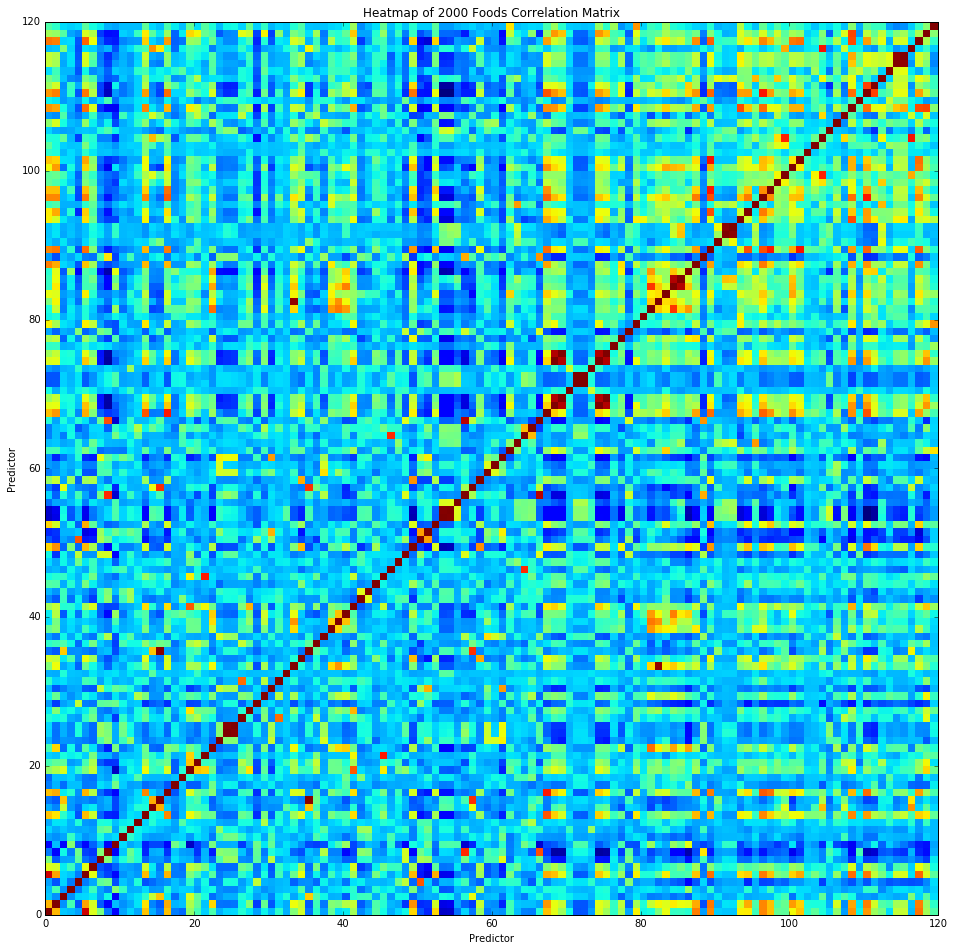

In [7]:
# Plot correlation matrices of agriculural and livestock data with filled-in data
fig, ax1 = plt.subplots(1, 1, figsize=(16, 16))
ax1=heatplotter(ax1,dinner)
plt.show() 

The white rows and columns have been removed from our dataframe, assuring us that we removed the right food groups. As we can see from the correlation heatmap, the agricultural and livestock predictors are largely uncorrelated with each other (with a few pairs being strongly correlated with each other, as seen as larger, deep red squares around the diagonal of self-correlation). This implies that if we do ultimately use subset selction, we should keep almost all of our predictors. 

As some of our countries are missing food data, we use a k-nearest neighbors approach to fill in the missing data, which we will describe in this section. We can justify using a k-nearest neighbors approach as food growth, trade and consumption is inherently linked to geographic location, so we can likely obtain a good estimate for a countries' consumption data by examining that of its neighbors. An analytical study (https://visualign.wordpress.com/2011/10/06/number-of-neighbors-for-world-countries/) reveals that the average number of bordering countries for a country in the world is 2.7, so we will use a 3-nearest-neighbors approach. First we initialize a function which returns the countries in our dataframe which are missing data, and test the results on our 2000 food consumption dataframe. Countries in our dataframe like "Czechoslovakia," "Ethiopia PDR," "USSR," "Yugoslav SFR" refer to previously existing countries that have been replaced by the Czech Republic and Slovakia, Ethiopia, the Russian Federation, and the former Yugoslav Republic of Macedonia respectively, all of which are in our dataframe and which we have data on, so considering that the years we are examining are after those countries dissolved we can ignore them in our analysis, dropping the number of valid countries from 182 to 172.

In [8]:
# Find countries for which we have NaN food consumption data
def nanCountries(df):
    # A list of countries and regionsin our dataframe that no longer existed within the years we are examining, 
    # and which we can choose to ignore
    outdated = ['Belgium-Luxembourg', 'Czechoslovakia', 'Ethiopia PDR', 'USSR', 'Yugoslav SFR', 'Eastern Europe', 'Serbia and Montenegro', 'Netherlands Antilles (former)']
    missingData = []
    for country in foodCountries:
        if df.loc[country].isnull().values.any() and country not in outdated:
            missingData.append(country)
    return missingData
print nanCountries(dinner)

['Montenegro', 'Serbia']


Now that we have a list of "NaN countries" in our dataframe that we wish to analyze we determine nearest neighbors using closest geographic location by largest city. We obtain a list of the most populated cities in each country (along with their latitudes and longitudes) from http://simplemaps.com/resources/world-cities-data, and create a dataframe using our data.

In [9]:
# City data obtained from http://simplemaps.com/resources/world-cities-data
citydata = pd.read_csv('data/world_cities.csv')
citydata.head()

,city,city_ascii,lat,lng,pop,country,iso2,iso3,province
0,Qal eh-ye Now,Qal eh-ye,34.983000,63.133300,2997.0,Afghanistan,AF,AFG,Badghis
1,Chaghcharan,Chaghcharan,34.516701,65.250001,15000.0,Afghanistan,AF,AFG,Ghor
2,Lashkar Gah,Lashkar Gah,31.582998,64.360000,201546.0,Afghanistan,AF,AFG,Hilmand
3,Zaranj,Zaranj,31.112001,61.886998,49851.0,Afghanistan,AF,AFG,Nimroz
4,Tarin Kowt,Tarin Kowt,32.633298,65.866699,10000.0,Afghanistan,AF,AFG,Uruzgan


For each country in our NaN countries list, we determine its largest city (by population) from our cities dataframe. We then find the largest city for every other country in our cities dataframe **for which we have food consumption data**, and find the three that our closest to our NaN country's city (calculated using Euclidean distance using latitude and longitude coordinates) and get their corresponding countries. The following function finds the nearest three countries for each country in an input missingData list.

In [10]:
# Find 3 nearest geographical neighbors among countries whose data we currently have (determined by city with highest 
# population's latitude and longitude) to fill in missing food consumption data
def findNearestThree(missingData):
    citydata = pd.read_csv('data/world_cities.csv')
    closest = {}
    # For now focus on countries that still exist during the times in which our disease data
    # was recorded (and thus have city data in 'world_cities.csv')
    for country in missingData:
        cities = citydata[citydata['country'] == country]
        # Get city with largest population among the data available to us
        #print country
        bigCity = cities.loc[cities['pop'] == cities['pop'].max()].index.tolist()[0]
        closestCountries = ['']*3
        closestValues = [sys.maxint]*3
        for otherCountry in citydata['country'].unique():
            if otherCountry not in missingData and otherCountry in foodCountries:
                otherCities = citydata[citydata['country'] == otherCountry]
                otherBigCity = otherCities.loc[otherCities['pop'] == otherCities['pop'].max()].index.tolist()[0]
                # To keep things simple we determine distance between cities using Euclidean distance
                distance = np.sqrt((citydata.iloc[bigCity]['lat'] - citydata.iloc[otherBigCity]['lat'] ) ** 2 + (citydata.iloc[bigCity]['lng'] - citydata.iloc[otherBigCity]['lng']) ** 2)
                for i in reversed(range(3)):
                    if distance < closestValues[i]:
                        if i == 0:
                            closestValues.insert(i, distance)
                            closestCountries.insert(i, citydata.iloc[otherBigCity]['country'])
                            del closestValues[-1]
                            del closestCountries[-1]
                            break
                        else:
                            continue
                    else:
                        if i < 2:
                            closestValues.insert(i+1, distance)
                            closestCountries.insert(i+1, citydata.iloc[otherBigCity]['country'])
                            del closestValues[-1]
                            del closestCountries[-1]
                            break
                        else:
                            break
        closest[country] = closestCountries
    return closest

Finally, given the three nearest neighbors for a given country, we have to fill in the missing data using the food consumption data of the neighboring countries. For each food group, we fill in a missing country's data using a normalized mean with respect to population of the neighboring countries' consumption data. To calculate this, we take the sum of the neighboring countries' consumption data for a specific food group and divide it by the sum of the populations of the neighboring countries' largest cities. We then take the product of this value with the population size of the missing countries' largest city to obtain a more accurate estimate of food consumption for that country with respect to population. The following function produces a new dataframe with the filled-in values for a given missing country.

In [11]:
# For each food group whose data we're missing for each country, we take the mean of the food group consumption of the three
# neighboring countries to fill in the missing data and normalize based on population
def fillFoodNeighbors(df, country, neighbors):
    citydata = pd.read_csv('data/world_cities.csv')
    totalPop = 0
    new = df.copy()
    # Get total population over all countries
    for neighbor in neighbors:
        cities = citydata[citydata['country'] == neighbor]
        totalPop += cities.loc[cities['pop'] == cities['pop'].max()]['pop'].tolist()[0]
    cities = citydata[citydata['country'] == country]
    countryPop = cities.loc[cities['pop'] == cities['pop'].max()]['pop'].tolist()[0]
    for food in foodGroups:
        if pd.isnull(df.loc[country][food]):
            prediction = 0
            for neighbor in neighbors:
                # Get total food group consumption over all countries
                prediction += df.loc[neighbor][food]
            # Normalize food group consumption with respect to country
            new[food][country] = prediction / totalPop * countryPop
    return new

To make sure our functions perform as expected, we try running our functions on our 2000 food consumption dataframe, checking the nearest neighbors for each NaN country as well as making sure the NaN countries' values have been filled in within our final dataframe.

In [12]:
# Fill in missing food consumption data for countries where we're missing data
missingData = nanCountries(dinner)
closest = findNearestThree(missingData)
for country in missingData:
    dinner = fillFoodNeighbors(dinner, country, closest[country])
    print "Missing Data Country:", country
    print "Nearest Neighbors:", closest[country]
# Find countries for which we have NaN food consumption data
missingData = nanCountries(dinner)
print "Countries of interest that are still missing data:", missingData

Missing Data Country: Montenegro
Nearest Neighbors: ['Albania', 'Bosnia and Herzegovina', 'Bulgaria']
Missing Data Country: Serbia
Nearest Neighbors: ['Bosnia and Herzegovina', 'Hungary', 'Albania']
Countries of interest that are still missing data: []


Looking at a world map, we see that the three closest countries that were selected for each of our 'missing data countries' appear visually to be close to or border that country, which is a good sanity check to make sure that our functions worked properly. In addition, it appears there are no more NaN countries we would want to fill in, ensuring our functions behaved as expected.

We now plot histograms collecting food group consumption rates into "range buckets" for all 172 countries for which we have food group consumption data. The x-axis indicates the range of consumption rates corresponding to a given "bar", and the y-axis indicates the number of countries with that consumption rate for a specific aggregate food type (e.g. "Bovine Meat" or "Freshwater Fish"). Again, all data was collected from the year 2000 for this particular experiment.

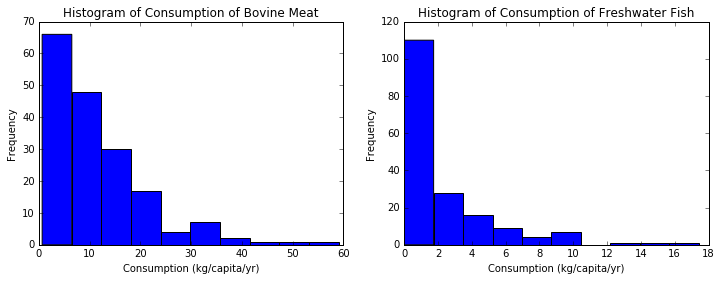

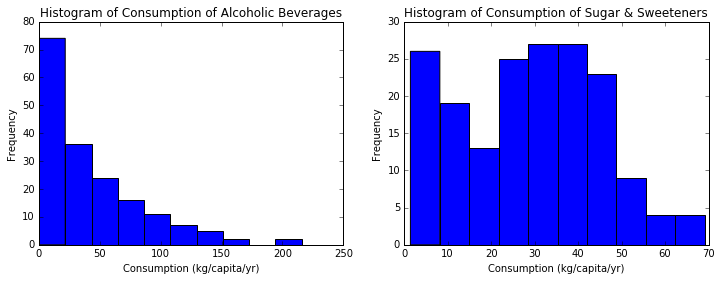

In [13]:
# function to plot histogram of food consumption
def foodplotter(ax,food):
    if food in dinner.columns.values:
        # indexes 182 to 216 are the aggregated regions, for countries we can to go from 0 to 181,:182.
        ax.hist(dinner[food].iloc[:182].dropna())
        ax.set_xlabel('Consumption (kg/capita/yr)')
        ax.set_ylabel('Frequency')
        ax.set_title('Histogram of Consumption of ' + food)
    else: 
        print "Food not found."
        return
    return ax

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0=foodplotter(ax0,'Bovine Meat')
ax1=foodplotter(ax1,'Freshwater Fish')
plt.show()

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0=foodplotter(ax0,'Alcoholic Beverages')
ax1=foodplotter(ax1,'Sugar & Sweeteners')
plt.show()

Some basic exploration of the data reveals some trends about food consumption. Livestock takes a lot of energy to raise, so high meat consumption is concentrated in a few wealthy countries who can afford the (energy) cost, so histograms of livestock consumption would be right-skewed to various degrees. Agriculture generally has a smaller energy cost, so we can see less skewed histograms, such as the one for Sugar & Sweeteners.

We now create a grouped bar chart showing diabetes mortality rate per 100,000 people for both sexes in each of the first 10 countries on which we have diabetes mortality data (countries are arranged in alphabetical order in our data frame) for the years 2000 and 2012. For each country, the first blue bar indicates 2000 mortality rates, while the second green bar indicates 2012 mortality rates for that country. We simply chose this "zoomed in" graph to show the details of our dataframe for our diabetes data. The x-axis shows countries while the y-axis shows mortality rates.

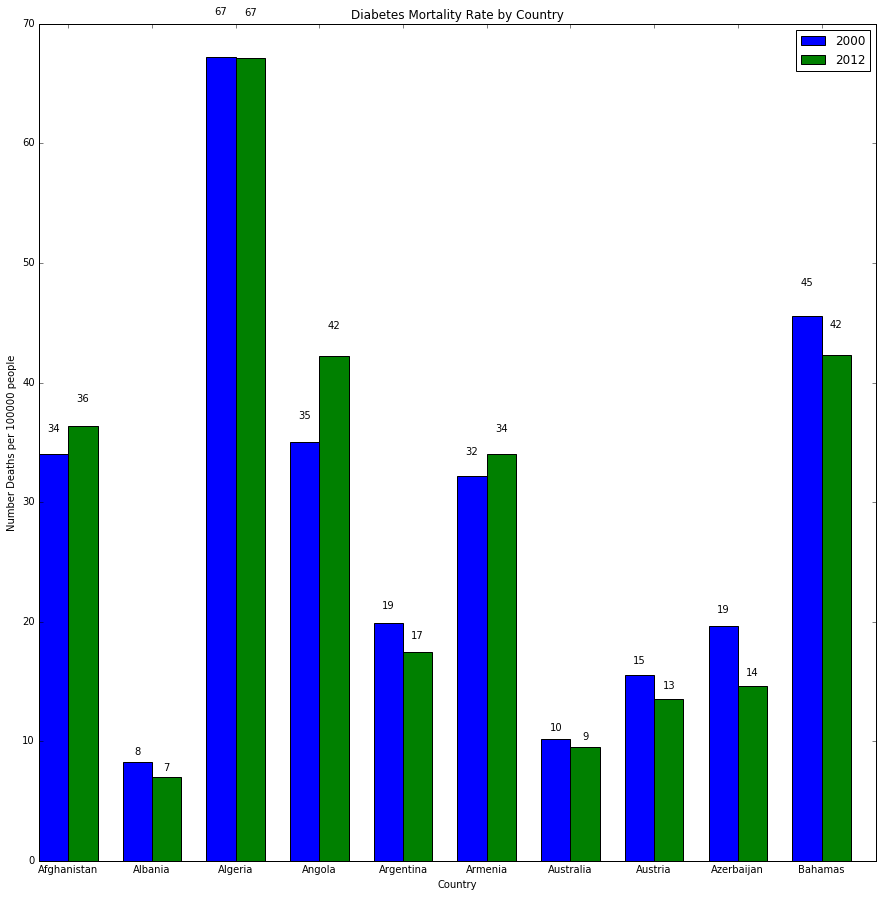

In [14]:
#Diabetes Grouped Bar Chart
newdata = diabdata[diabdata['Year'] == 2012]
olddata = diabdata[diabdata['Year'] == 2000]
N = len(newdata)

ind = np.arange(10)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
rects1 = ax.bar(ind, olddata[' Both sexes'][:10], width, color='b')
rects2 = ax.bar(ind + width, newdata[' Both sexes'][:10], width, color='g')

# add some text for labels, title
ax.set_xlabel('Country')
ax.set_ylabel('Number Deaths per 100000 people')
ax.set_title('Diabetes Mortality Rate by Country')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(olddata['Country'][:10]))

ax.legend((rects1[0], rects2[0]), ('2000', '2012'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

To expand our view, we create another grouped bar chart that has diabetes mortality rates for both sexes for all 172 countries on which we now have data. Here the x-axis corresponds to the country's "index" in our dataframe (countries are ordered alphabetically, so position 0 corresponds to the first country name alphabetically, and position 181 corresponds to the last country name alphabetically). Again, data was collected for the years 2000 and 2012.

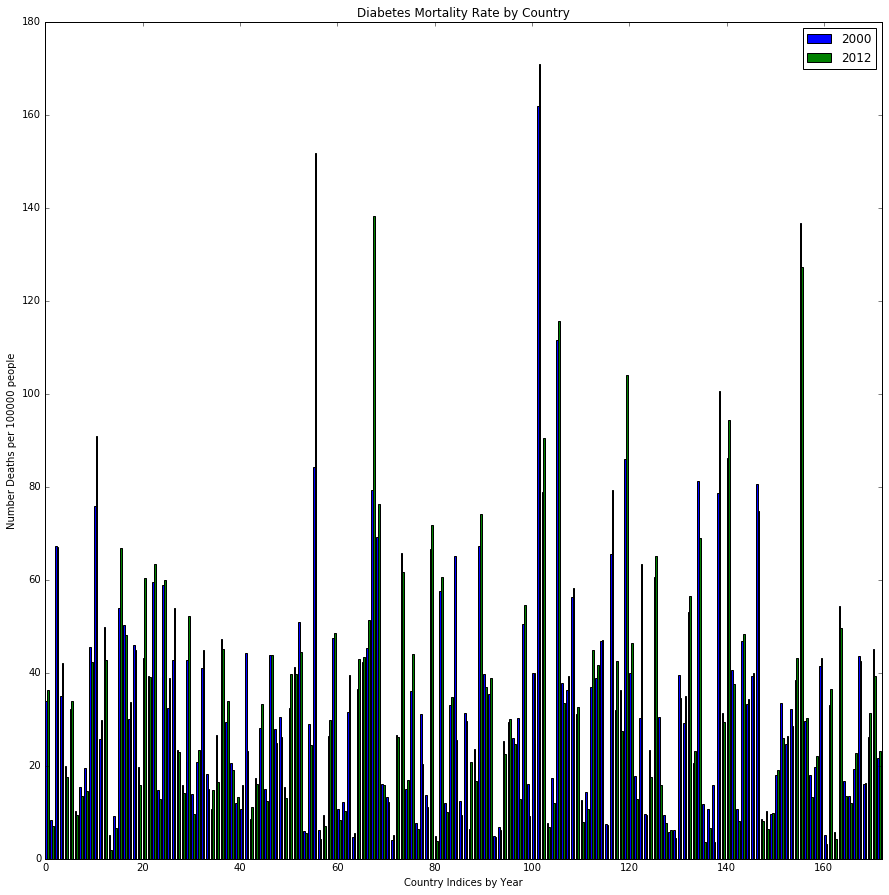

In [15]:
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
rects1 = ax.bar(ind, olddata[' Both sexes'], width, color='b')
rects2 = ax.bar(ind + width, newdata[' Both sexes'], width, color='g')

# add some text for labels, title
ax.set_xlabel('Country Indices by Year')
ax.set_ylabel('Number Deaths per 100000 people')
ax.set_title('Diabetes Mortality Rate by Country')

ax.legend((rects1[0], rects2[0]), ('2000', '2012'))
ax.set_xlim([0,N])

plt.show()

To create a World Map with our data, we used Cartopy. We first realized that some of our country names did not correspond to their Cartopy counterparts, so we wrote the following helper function to create a copy dataframe with the "correct" country names for Cartopy.

In [16]:
# Changes certain country names from our dataset so that they are equivalent to those used by Cartopy
def cleanCountryNames(df):
    new = df.copy()
    new.set_value(df[df['Country'] == 'The former Yugoslav republic of Macedonia'].index.tolist()[0], "Country", "Macedonia")
    new.set_value(df[df['Country'] == 'Iran (Islamic Republic of)'].index.tolist()[0], "Country", "Iran")
    new.set_value(df[df['Country'] == 'Democratic People\'s Republic of Korea'].index.tolist()[0], "Country", "Dem. Rep. Korea")
    new.set_value(df[df['Country'] == 'Republic of Moldova'].index.tolist()[0], "Country", "Moldova")
    new.set_value(df[df['Country'] == 'Syrian Arab Republic'].index.tolist()[0], "Country", "Syria")
    new.set_value(df[df['Country'] == 'United Kingdom of Great Britain and Northern Ireland'].index.tolist()[0], "Country", "United Kingdom")
    new.set_value(df[df['Country'] == 'Cote d\'Ivoire'].index.tolist()[0], "Country", "C\xf4te d\'Ivoire")
    new.set_value(df[df['Country'] == 'United States of America'].index.tolist()[0], "Country", "United States")
    new.set_value(df[df['Country'] == 'Bolivia (Plurinational State of)'].index.tolist()[0], "Country", "Bolivia")
    new.set_value(df[df['Country'] == 'Lao People\'s Democratic Republic'].index.tolist()[0], "Country", "Lao PDR")
    new.set_value(df[df['Country'] == 'Gambia'].index.tolist()[0], "Country", "The Gambia")
    new.set_value(df[df['Country'] == 'Venezuela (Bolivarian Republic of)'].index.tolist()[0], "Country", "Venezuela")
    new.set_value(df[df['Country'] == 'Viet Nam'].index.tolist()[0], "Country", "Vietnam")
    new.set_value(df[df['Country'] == 'Congo'].index.tolist()[0], "Country", "Republic of Congo")
    new.set_value(df[df['Country'] == 'United Republic of Tanzania'].index.tolist()[0], "Country", "Tanzania")
    return new

We now generate a world map displaying countries color-coded by their diabetes mortality rates for both sexes for the year 2000. Countries that are shaded white had lower death rates, while those shaded red had higher death rates. Countries shaded green are countries for which we do not have mortality data. While we considered using a geographical k-nearest neighbors approach, since no scientific correlation has been shown between geographic location and diabetes mortality rate in past research, we deemed such an approach scientifically unsound.

In [17]:
# Generates a world map color-coded by disease mortality rates given a dataframe
def mapMortalities(data, name):
    fig, ax = plt.subplots(figsize=(20,40))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.set_extent([-150, 60, -25, 60])

    # Clean country data
    countrydata = cleanCountryNames(data)

    # Set up coloring map
    cmap = plt.get_cmap('Oranges')   
    norm = Normalize()
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    mapper.set_array(countrydata[' Both sexes'])
    plt.colorbar(mapper, shrink=0.4)

    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    countryNames = set(countrydata["Country"])

    for country in countries:
        if country.attributes['name_long'] in countryNames:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=cmap(norm(countrydata.loc[countrydata['Country'] == country.attributes["name_long"]][" Both sexes"])),
                              label=country.attributes['adm0_a3'])
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=(0, 1, 0),
                              label=country.attributes['adm0_a3'])
    plt.title(name)
    plt.show()

We create a color-coded map of 2000 diabetes mortality rates per 100000 people for both sexes by country by running the following:

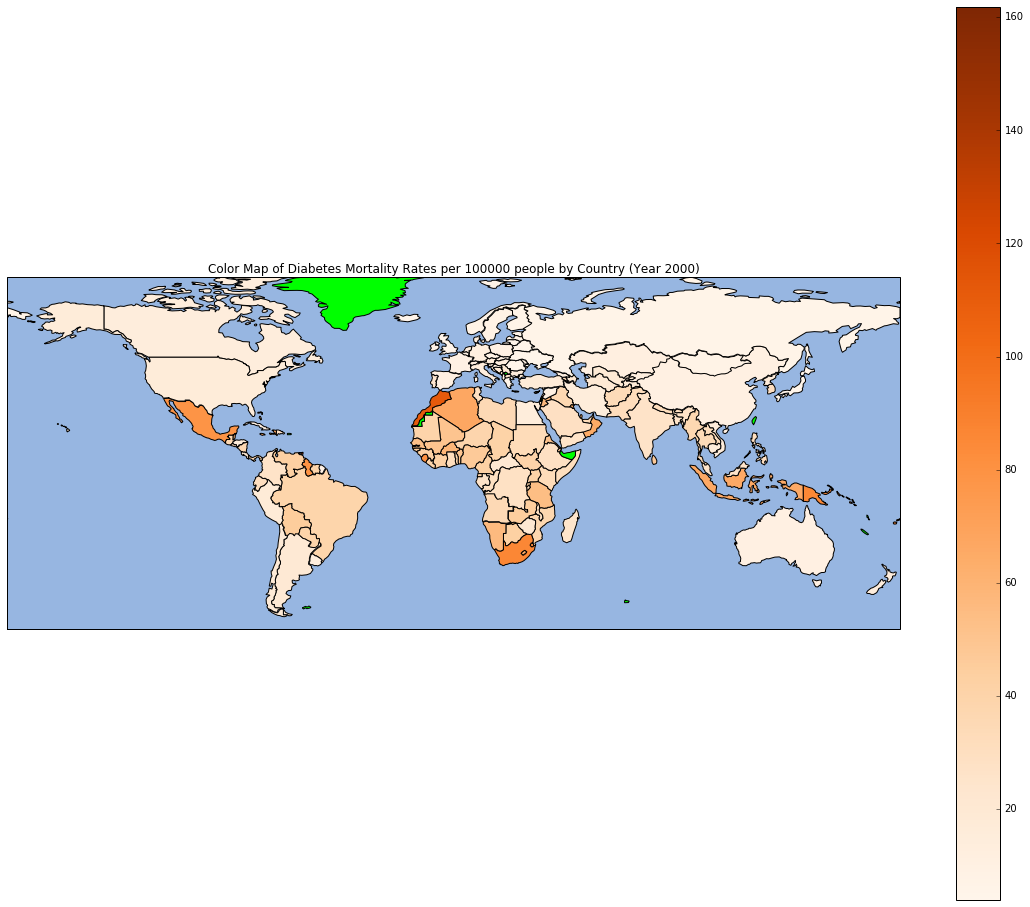

In [18]:
# Set up world map for 2000 Diabetes Rates
mapMortalities(olddata, "Color Map of Diabetes Mortality Rates per 100000 people by Country (Year 2000)")

We repeat this process for 2012 diabetes mortality rates per 100000 people for both sexes by country.

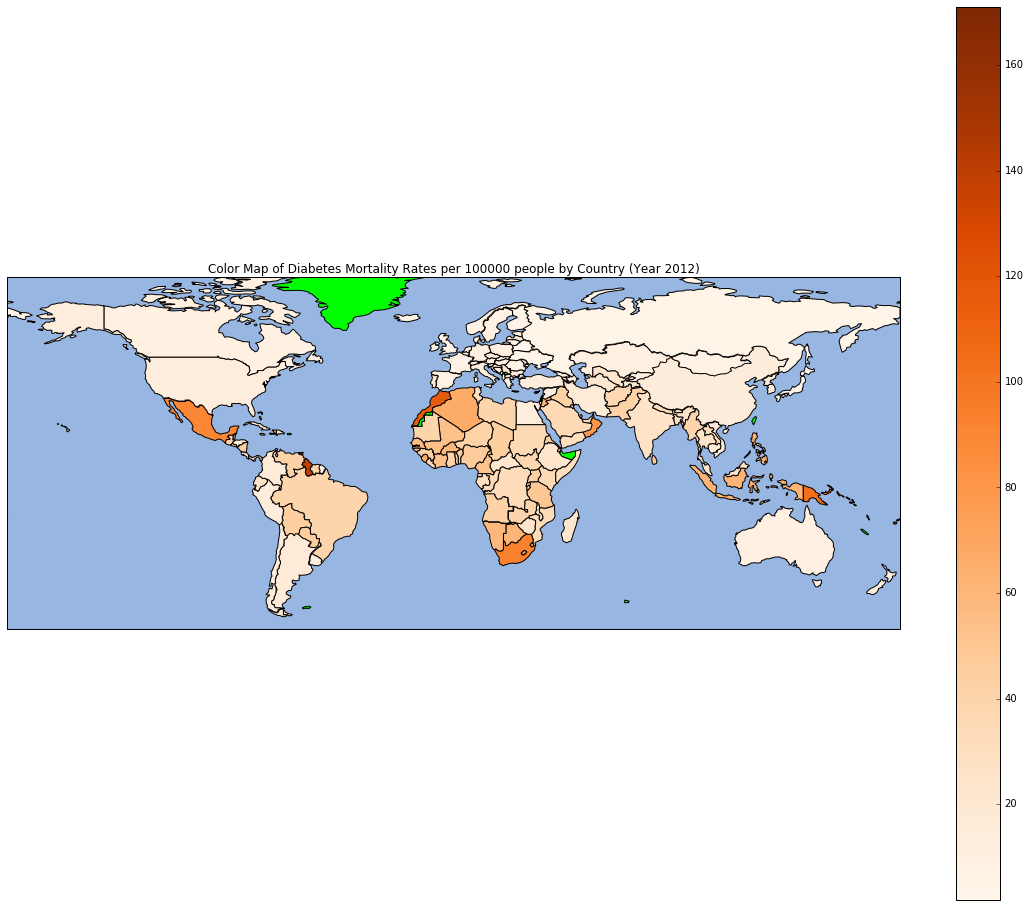

In [19]:
# Set up world map for 2012 Diabetes Rates
mapMortalities(newdata, "Color Map of Diabetes Mortality Rates per 100000 people by Country (Year 2012)")

We set up a third world map that color-codes countries by percentage change in diabetes mortality rates from 2000 to 2012. Blue countries are countries that experienced a decrease in mortality rates, while red countries are countries that experienced an increase. Both countries that are "significantly red" or "significantly blue" would be worth investigating for our project to see if changes in food consumption affect diabetes mortality rates.

In [20]:
# Generates a world map color-coded by changes in disease mortality rates given a dataframe
def mapMortalityChanges(old, new, name):
    # Set up world map for change in Diabetes Rate from 2000 to 2012
    fig, ax = plt.subplots(figsize=(20,40))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.set_extent([-150, 60, -25, 60])

    # Clean country data
    countrydata = cleanCountryNames(new)
    for i in range(len(countrydata)):
        countrydata.set_value(2*i, " Both sexes", 100*float(new.iloc[i][" Both sexes"] - old.iloc[i][" Both sexes"]) / float(old.iloc[i][" Both sexes"]))

    # Set up coloring map
    cmap = plt.get_cmap('seismic')   
    norm = Normalize()
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Ensure our color mapping is centered around zero
    mapper.set_array([countrydata[' Both sexes'].abs().max(), -1*countrydata[' Both sexes'].abs().max()])
    plt.colorbar(mapper, shrink=0.4)

    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    countryNames = set(countrydata["Country"])

    for country in countries:
        if country.attributes['name_long'] in countryNames:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=cmap(norm(countrydata.loc[countrydata['Country'] == country.attributes["name_long"]][" Both sexes"])),
                              label=country.attributes['adm0_a3'])
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=(0, 1, 0),
                              label=country.attributes['adm0_a3'])
    plt.title(name)
    plt.show()

We map changes in diabetes mortality rates from 2000 to 2012 by running the following:

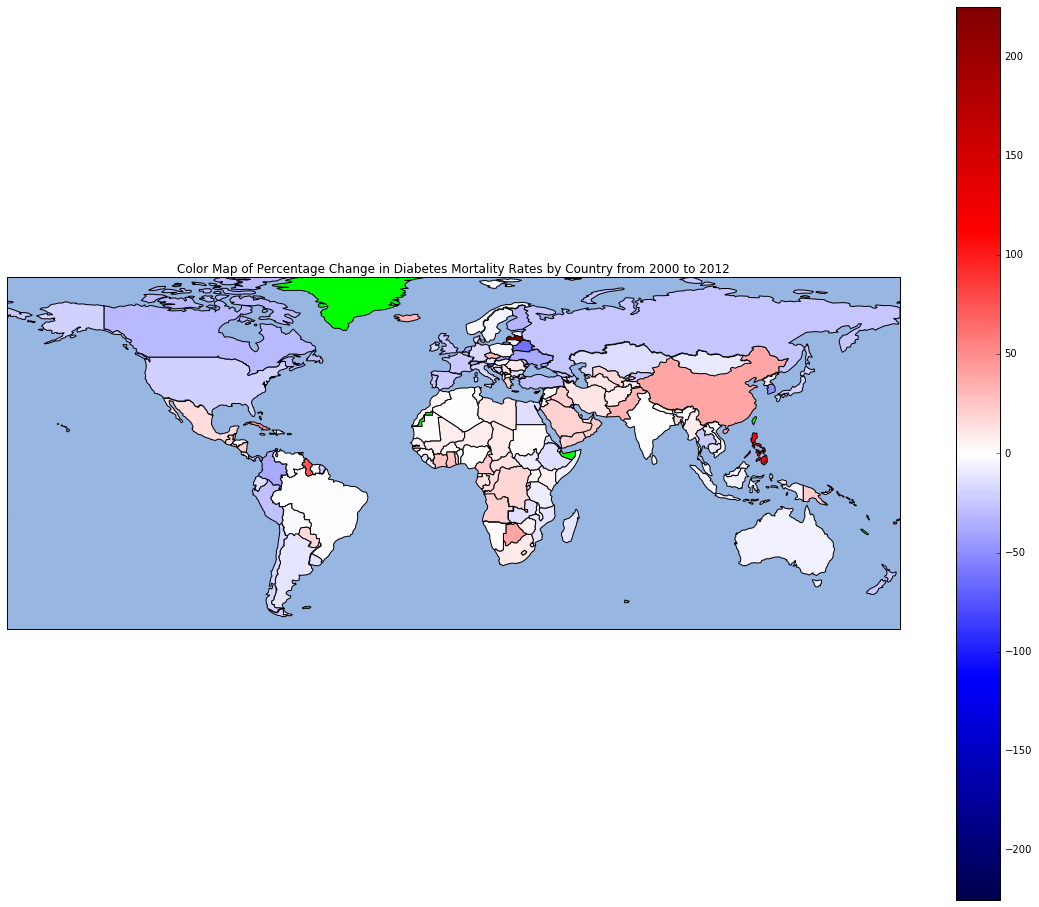

In [21]:
# Set up world map for change in Diabetes Rate from 2000 to 2012
mapMortalityChanges(olddata, newdata, "Color Map of Percentage Change in Diabetes Mortality Rates by Country from 2000 to 2012")

Investigating the changes in diabetes rates from 2000 to 2012 may be an interesting idea for a future project, but for now we simply wanted to provide a visual for diabetes prevalence throughout the world based on our data.

We now create a grouped bar chart that has cardiovascular disease mortality rates per 100000 people for both sexes for all 172 countries on which we have data. Here the x-axis corresponds to the country's "index" in our dataframe (countries are ordered alphabetically, so position 0 corresponds to the first country name alphabetically, and position 171 corresponds to the last country name alphabetically). The y-axis corresponds to the number of deaths per 100000 people for that country for a given year. Again, data was collected for the years 2000 and 2012.

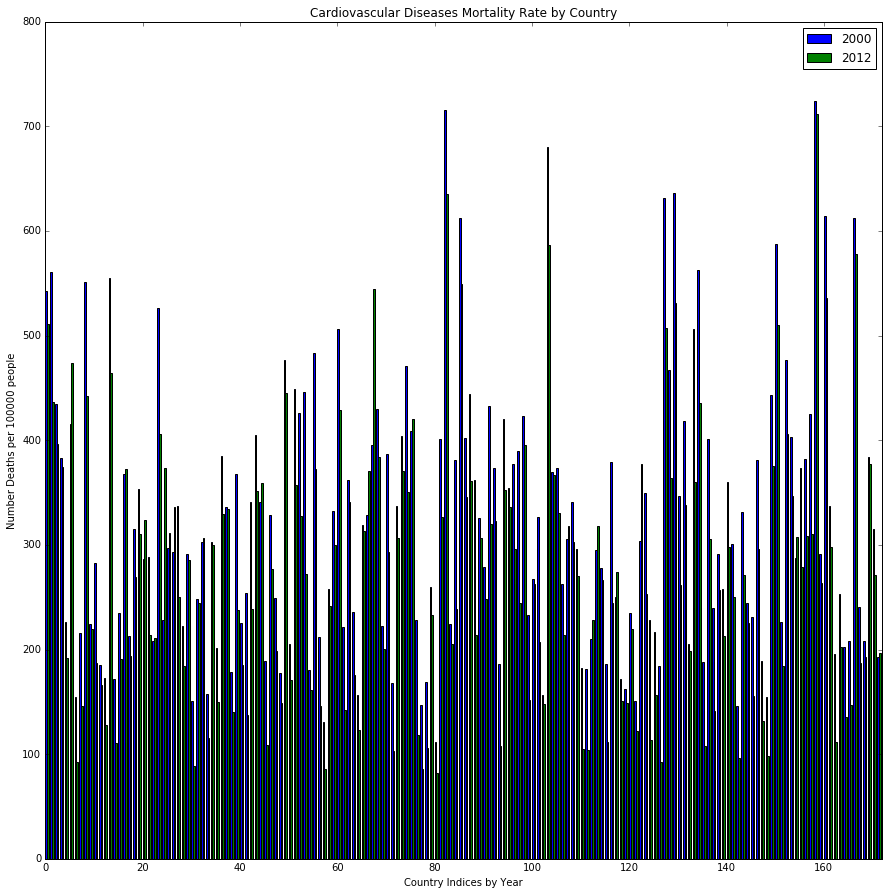

In [22]:
#Cardio Grouped Bar Chart
newdata = cardiodata[cardiodata['Year'] == 2012]
olddata = cardiodata[cardiodata['Year'] == 2000]
N = len(newdata)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
rects1 = ax.bar(ind, olddata[' Both sexes'], width, color='b')
rects2 = ax.bar(ind + width, newdata[' Both sexes'], width, color='g')

# add some text for labels, title
ax.set_xlabel('Country Indices by Year')
ax.set_ylabel('Number Deaths per 100000 people')
ax.set_title('Cardiovascular Diseases Mortality Rate by Country')

ax.legend((rects1[0], rects2[0]), ('2000', '2012'))
ax.set_xlim([0,N])

plt.show()

We now generate a world map displaying countries color-coded by their cardiovascular disease mortality rates for both sexes for the year 2000. Countries that are shaded white had lower death rates, while those shaded red had higher death rates. Countries shaded green are countries for which we do not have mortality data. While we considered using a geographical k-nearest neighbors approach, as no scientific correlation has been shown between geographic location and cardiovascular disease mortality rate in past research, we deemed such an approach scientifically unsound.

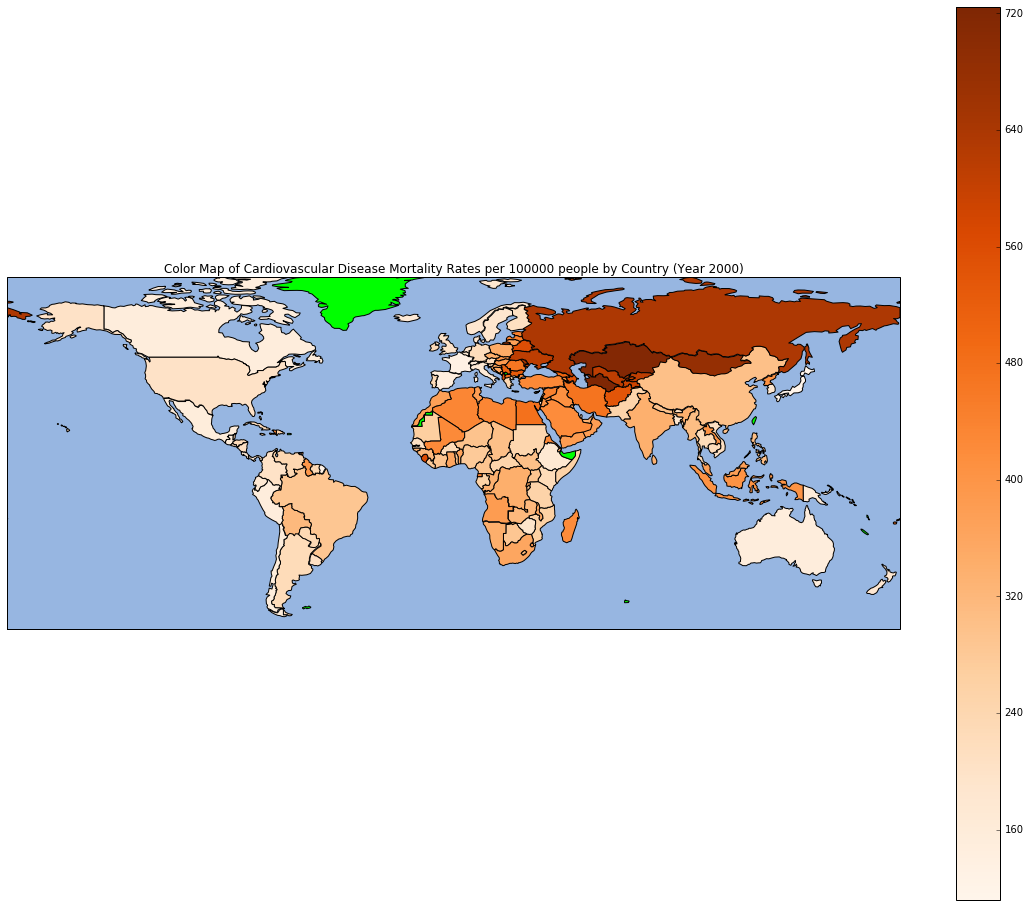

In [23]:
# Set up world map for 2000 Cardio Rates
mapMortalities(olddata, "Color Map of Cardiovascular Disease Mortality Rates per 100000 people by Country (Year 2000)")

We repeat this process for 2012 cardiovascular disease mortality rates per 100000 people for both sexes by country.

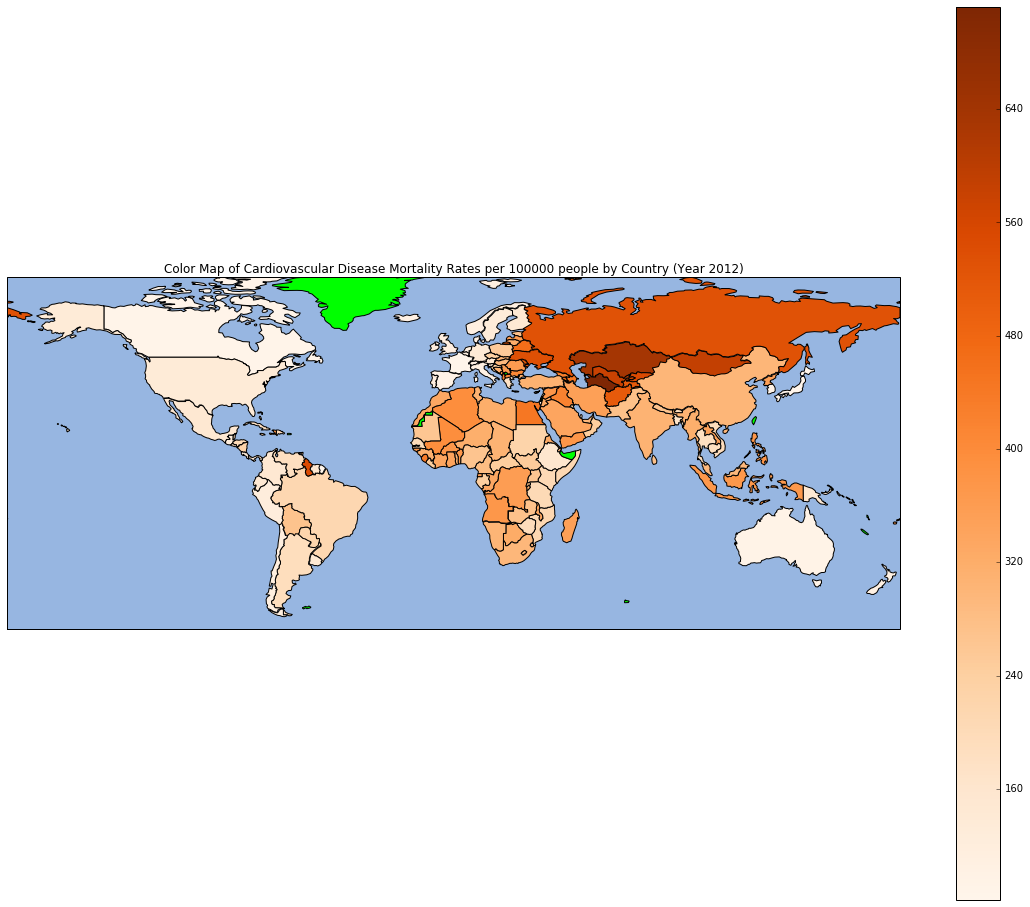

In [24]:
# Set up world map for 2012 Cardio Rates
mapMortalities(newdata, "Color Map of Cardiovascular Disease Mortality Rates per 100000 people by Country (Year 2012)")

We set up a third world map that color-codes countries by percentage change in cardiovascular disease mortality rates from 2000 to 2012. Blue countries are countries that experienced a decrease in mortality rates, while red countries are countries that experienced an increase. Both countries that are "significantly red" or "significantly blue" would be worth investigating for our project to see if changes in food consumption affect cardiovascular disease mortality rates.

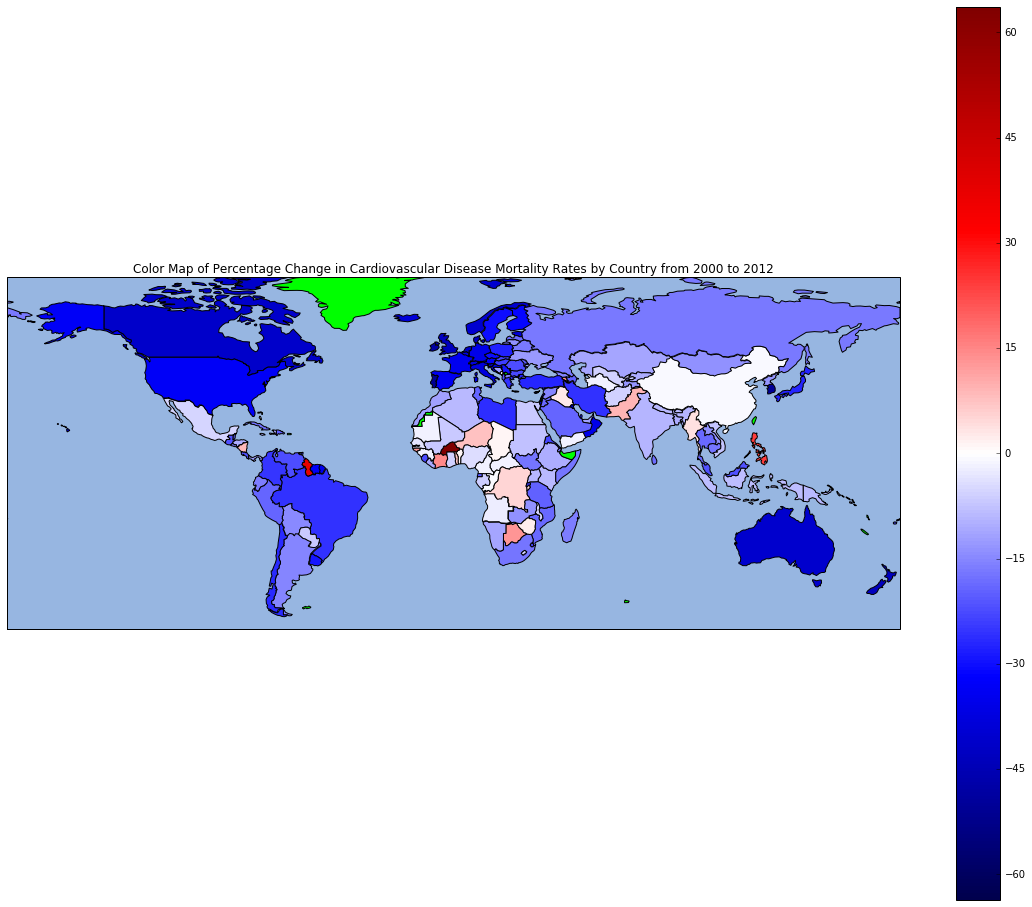

In [25]:
# Set up world map for change in Cardio Rate from 2000 to 2012
mapMortalityChanges(olddata, newdata, "Color Map of Percentage Change in Cardiovascular Disease Mortality Rates by Country from 2000 to 2012")

Investigating the changes in diabetes rates from 2000 to 2012 may be an interesting idea for a future project, but for now we simply wanted to provide a visual for diabetes prevalence throughout the world based on our data.

Finally, as a test to check for correlation, we generated "mini heat maps" to check for correlations between each food item, or aggregates of items, and disease incidence. In order to do this, we must first create a combined food-data / disease table after determining which countries are common to both our food data and disease tables. We start with our diabetes data:

In [26]:
disease=pd.read_csv('data/DiabetesDeathRate.csv')
Dc=list(set(disease['Unnamed: 0']))
import copy
Fc=washed.index.values
overlap=[]
outlier=[]
for country in Fc:
    if country in Dc:
        overlap.append(country)
    else:
        outlier.append('F-'+str(country))
for country in Dc:
    if country not in overlap:
        outlier.append('D-'+str(country))
outlier=sorted(outlier,key=str.lower)

After finding the countries that are present in both the food consumption rate and diabetes mortality dataframes (stored in overlap) we combine the two dataframes for the countries that are present in both dataframes to create a new dataframe (combined).

In [27]:
foodOverlap = dinner.ix[overlap]
diabOverlap = diabdata[diabdata["Country"].isin(overlap)]
diabOverlap = diabOverlap[diabOverlap["Year"] == 2012]
combined = foodOverlap.copy()
mortality = np.around(list(diabOverlap[" Both sexes"]), decimals=1)
combined["Diabetes Mortality"] = pd.Series(mortality, index=combined.index)
print combined.head()

             Alcoholic Beverages  Apples and products  Bananas  \
Afghanistan                 0.00                 0.40     0.03   
Albania                    15.73                10.94     5.40   
Algeria                     3.17                 2.89     0.00   
Angola                     15.94                 0.21    18.31   
Argentina                  68.69                14.21    12.97   

             Barley and products  Beans   Beer  Beverages, Alcoholic  \
Afghanistan                 4.06   0.00   0.00                  0.00   
Albania                     0.15   4.84  12.49                  0.93   
Algeria                     9.19   1.11   3.16                  0.00   
Angola                      0.00   7.07   8.73                  0.50   
Argentina                   0.11   0.15  33.04                  1.77   

             Beverages, Fermented  Cassava and products  \
Afghanistan                  0.00                   0.0   
Albania                      0.01                   

Now that we note that the Diabetes Mortality Rate is in the final column of our combined dataframe, we look at the correlation heat map for JUST the last column to determine the correlation between diabetes mortality rate with each of our food groups. In this case, we are examining the correlation between food group consumption (index on the x-axis) in the year 2000 and diabetes mortality rate in the year 2012. While there may not be significant correlations here, we can modify this flexibly for a wide range of years depending on what we want to examine.

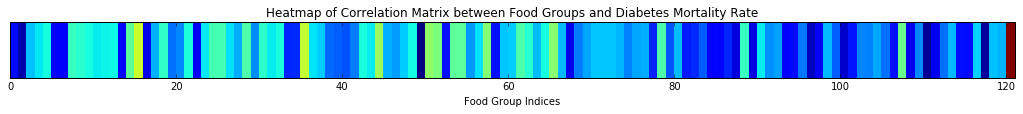

In [28]:
# Compute matrix of correlation coefficients
corr_matrix = combined.corr()

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(18, 1))

Zm = ma.masked_where(np.isnan(corr_matrix),corr_matrix)
plt.pcolormesh(Zm)

ax.set_title('Heatmap of Correlation Matrix between Food Groups and Diabetes Mortality Rate')
ax.set_xlabel('Food Group Indices')
ax.set_ylabel('Mortality Rate')
ax.set_ylim([len(combined.columns.values)-1,len(combined.columns.values)])
ax.set_xlim([0,len(combined.columns.values)])
ax.yaxis.set_visible(False)
plt.show()

Ignoring the last column (where the diabetes mortality rate predictor would naturally be perfectly correlated with itself and provides a good sanity check) as well as the "white columns" for which we have no data, we note that a number of predictors appear to be "mildly correlated" with diabetes mortality rate (the "yellow columns" but overall there appears to be no strong correlation. We will more robustly construct a model to predict disease mortality rates based on past food consumption in our "Modeling and Classification" section, but we just wanted to demonstrate the functionality of our code here. Next, we perform the same process for our Cardio Disease Mortality Rate data by first finding "overlapping countries" between our Cardio Mortality Rate dataframe and our 2000 food group consumption rate dataframe.

In [29]:
disease=pd.read_csv('data/CardioDeathRate.csv')
Dc=list(set(disease['Unnamed: 0']))
Fc=washed.index.values
overlap=[]
outlier=[]
for country in Fc:
    if country in Dc:
        overlap.append(country)
    else:
        outlier.append('F-'+str(country))
for country in Dc:
    if country not in overlap:
        outlier.append('D-'+str(country))
outlier=sorted(outlier,key=str.lower)

After finding the overlapping countries we again combine our 2000 food group consumption rate dataframe and our 2012 cardio disease mortality rate dataframe for countries where we have data in both dataframes.

In [30]:
foodOverlap = dinner.ix[overlap]
cardioOverlap = cardiodata[cardiodata["Country"].isin(overlap)]
cardioOverlap = cardioOverlap[cardioOverlap["Year"] == 2012]
combined = foodOverlap.copy()
mortality = np.around(list(cardioOverlap[" Both sexes"]), decimals=1)
combined["Cardio Diseases Mortality"] = pd.Series(mortality, index=combined.index)
print combined.head()

             Alcoholic Beverages  Apples and products  Bananas  \
Afghanistan                 0.00                 0.40     0.03   
Albania                    15.73                10.94     5.40   
Algeria                     3.17                 2.89     0.00   
Angola                     15.94                 0.21    18.31   
Argentina                  68.69                14.21    12.97   

             Barley and products  Beans   Beer  Beverages, Alcoholic  \
Afghanistan                 4.06   0.00   0.00                  0.00   
Albania                     0.15   4.84  12.49                  0.93   
Algeria                     9.19   1.11   3.16                  0.00   
Angola                      0.00   7.07   8.73                  0.50   
Argentina                   0.11   0.15  33.04                  1.77   

             Beverages, Fermented  Cassava and products  \
Afghanistan                  0.00                   0.0   
Albania                      0.01                   

Now that we note that the Cardio Disease Mortality Rate is in the final column of our combined dataframe, we look at the correlation heat map for JUST the last column to determine the correlation between cardio disease mortality rate with each of our food groups. In this case, we are examining the correlation between food group consumption (index on the x-axis) in the year 2000 and cardio disease mortality rate in the year 2012. While there may not be significant correlations here, we can modify this flexibly for a wide range of years depending on what we want to examine.

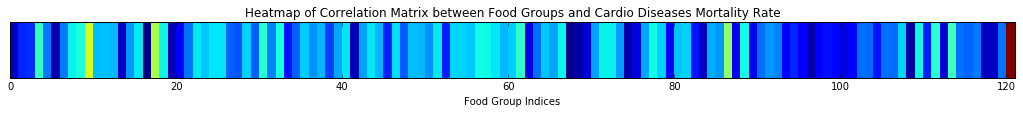

In [31]:
#print foods
#print np.cov(X)
# Compute matrix of correlation coefficients
corr_matrix = combined.corr()
#print corr_matrix
# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(18, 1))

Zm = ma.masked_where(np.isnan(corr_matrix),corr_matrix)
plt.pcolormesh(Zm)
#ax.pcolor(corr_matrix)

ax.set_title('Heatmap of Correlation Matrix between Food Groups and Cardio Diseases Mortality Rate')
ax.set_xlabel('Food Group Indices')
ax.set_ylabel('Mortality Rate')
ax.set_ylim([len(combined.columns.values)-1,len(combined.columns.values)])
ax.set_xlim([0,len(combined.columns.values)])
ax.yaxis.set_visible(False)
plt.show()

Again, the last column being completely red indicates that the Cardio Mortality Rate predictor is perfectly correlated with itself, serving as a good sanity check for our work. Most of the columns in this "mini heat map" are blue, indicating little correlation, though we may consider exploring the food groups associated with the yellow "mild correlation" columns for both diseases in our project investigation. We will expand our analysis and actually develop prediction models in the following section.

First, for the sake of convenience, we create two functions that will return all the consumption data for all countries for a given year and a range of years, using a similar process as the one used to load in data as seen above. Here, we will create a function which runs the entire consumption data cleaning proceedure for a given year and return the resulting dataset. First, the function takes the inputted year and iterates through the agriculture and livestock data, appending new countries by filling out the data for each food item and ultimately concatenating the agri and meat datasets together. Second, missing data is filled with the geographical 3-nearest neighbors algorithm described above (when possible). Finally, the cleaned "dinner" data is returned.

In [32]:
def dinneryear(year):
    # prepare to clean data
    agricountries=[]
    agri=sorted(list(set(agridata['Item'])),key=str.lower)
    year='Y'+str(year)
    X=[]
    observation=list(np.zeros(len(agri)))
    # iterate through 'units' column
    for i in agridata.index:
        # if appropriate unit found, begin appending data
        if agridata['Element'].iloc[i] == 'Food supply quantity (kg/capita/yr)':
            # if we haven't seen this country
            if agridata['Country'].iloc[i] not in agricountries:
                if i > 4:
                    # we found a new country and can record the current observation
                    X.append(observation)
                # and start recording a new country's data 
                agricountries.append(agridata['Country'].iloc[i])
                observation=list(np.zeros(len(agri)))
            # find appropriate column for food consumption value
            k=agri.index(agridata['Item'].iloc[i])
            # append country's consumption of food (kg/capita/yr) to observation list for given year      
            observation[k]=agridata[year].iloc[i]
    # append last observation
    X.append(observation)
    washed=pd.DataFrame(data=np.array(X),index=agricountries,columns=agri)
   
    # prepare to clean data
    meatcountries=[]
    meat=sorted(list(set(meatdata['Item'])),key=str.lower)
    X=[]
    observation=list(np.zeros(len(agri)))
    # iterate through 'units' column
    for i in meatdata.index:
        # if appropriate unit found, begin appending data
        if meatdata['Element'].iloc[i] == 'Food supply quantity (kg/capita/yr)':
            # if we haven't seen this country
            if meatdata['Country'].iloc[i] not in meatcountries:
                if i > 4:
                    # we found a new country and can record the current observation
                    X.append(observation)
                # and start recording a new country's data 
                meatcountries.append(meatdata['Country'].iloc[i])
                observation=list(np.zeros(len(meat)))
            # find appropriate column for food consumption value
            k=meat.index(meatdata['Item'].iloc[i])
            # append country's consumption of food (kg/capita/yr) to observation list for given year      
            observation[k]=meatdata[year].iloc[i]
    # append last observation
    X.append(observation)
    cooked=pd.DataFrame(data=np.array(X),index=meatcountries,columns=meat)
    dinner=pd.concat([washed,cooked], axis=1, join='inner')
    # 2012 has too much missing data
    if year != 'Y2012':
        foodCountries=list(dinner.index.values)
        # remove redundant categories
        del dinner["Grand Total"]
        dinner, _ = removeMissing(dinner)
        foodGroups = list(dinner.columns.values)
        foodCountries = list(dinner.index.values)
        # fill in missing values
        missingData = nanCountries(dinner)
        closest = findNearestThree(missingData)
        for country in missingData:
            dinner = fillFoodNeighbors(dinner, country, closest[country])
    return dinner

To create a dataset of average consumption over an interval, we create a base dataset. Then as we iterate through the inputted range of years, for each new year we create a temporary dataset and add its values to the base dataset. Finally, we divide every element in the base dataset by the number of years to get the yearly average. The following function accomplishes this for a given range of years.

In [33]:
def dinnerint(yearrange):
    dinner0 = dinneryear(yearrange[0])
    if len(yearrange)>1:
        for i in range(1,len(yearrange)):
            dinner=dinneryear(yearrange[i])
            if len(dinner0) == len(dinner):
                for col in dinner0.columns.values:
                    dinner0[col] = dinner0[col].add(dinner0[col])
            else:
                print str(yearrange[i]) + ' has a different number of countries as', yearrange[0]
        dinner0.divide(len(yearrange))
    return dinner0

To successfully fit and score our models, we must determine the common countries between food consumption and disease data for a given year. The following function serves to find the common rows in both food consumption and disease dataframes for a given year and returns the resulting predictors and response variables as a tuple.

In [34]:
def xyreturner(dinner,disease,disease_year):
    diabdata = pd.read_csv('data/DiabetesDeathRate.csv', skiprows=2)
    cardiodata = pd.read_csv('data/CardioDeathRate.csv', skiprows=2)
    if disease.equals(diabdata) or disease.equals(cardiodata): 
        # use disease data     
        Dc=list(set(disease['Country']))
        Fc=dinner.index.values        
        overlap=[]
        for country in Fc:
            if country in Dc:
                overlap.append(country)
        foodOverlap = dinner.ix[overlap]      
        diseaseOverlap = disease[disease["Country"].isin(overlap)]
        diseaseOverlap = diseaseOverlap[diseaseOverlap["Year"] == disease_year]
        combined = foodOverlap.copy()
        mortality = np.around(list(diseaseOverlap[" Both sexes"]), decimals=1)
        combined["Diabetes Mortality"] = pd.Series(mortality, index=combined.index)
    else:
        print "Error: Disease dataframe not recognized"
        return 
    
    y=combined[combined.columns.values[-1]]
    x=combined[combined.columns.values[:-1]]
    return x, y

To find the top k most important predictors, we look the predictors with the largest absolute values. The function topmagnitude() takes a model, the Xs it was trained on, and k. First, the function creates a dictionary to associate each coefficient with its corresponding predictor. Then, it sorts the list of absolute(coefficients) and begins iterating from back to front, using the aforementioned dictionary to create a list containing the top k coefficients and one containing their predictors.

In [35]:
def topMagnitude(model,X,k):
    # create dictionary of coefficient:predictor
    CoefX={model.coef_[i]:X.columns.values[i]  for i in range(len(model.coef_))}
    # if total # of coefficients is less than k, only print the coefficients we have
    if k > len(CoefX):
        k = len(CoefX)
    # list of coefficient magnitudes
    magnitude=[]
    for ele in model.coef_:
        if ele == 0:
            magnitude += [0]
        else:
            magnitude += [int(math.log10(abs(ele)))]   
    # initialize lists to hold the top k absolute largest coefficients
    # and their corresponding predictors in parallel
    topX=[]
    topcoef=[]
    # print top k absolute largest coefficients        
    for i in range(1,k+1):
        # use the negative as a key if the positive/absolute
        # value isn't in the dictionary
        if sorted(abs(model.coef_))[-i] not in CoefX:
            topX += [CoefX[-sorted(abs(model.coef_))[-i]]]
            topcoef += [-sorted(abs(model.coef_))[-i]]
        else:
            topX += [CoefX[sorted(abs(model.coef_))[-i]]]
            topcoef += [sorted(abs(model.coef_))[-i]]
    return topX, topcoef, magnitude

While topmagnitude() returns the coefficients and their related predictors organized by absolute value, this won't make for good visualization, as we will want to account for the coefficients' signs when sorting. To that end, toporder() takes the coefficients and predictors from topmagnitude(), reverse iterating through them, and constructs the reorganized lists by prepending negative values/predictors and appending positive ones.

In [36]:
def topOrder(model,X,k):
    # get predictor names and coefficients from topmagnitude
    X, Y, _ = topMagnitude(model,X,k)
    # initialize lists to hold smallest to largest rather than largest-smallest by magnitude
    sortedX=[]
    sortedY=[]
    # iterate from the bottom up
    for i in range(1,k+1):
        # if its negative then it goes to the front
        if Y[-i] < 0:
            sortedY.insert(0, Y[-i])
            sortedX.insert(0, X[-i])
        # if it's not, then it goes to the back
        else:
            sortedY.append(Y[-i])
            sortedX.append(X[-i])
    # return the sorted coefficients and their corresponding predictors
    return sortedX, sortedY

We now want to create baseline linear models to try to predict disease mortality rates using historical food consumption data. We first load in all our disease data and prepare to work from two separate sets of consumption data, one for 1999 and the other for 2011. The reason we choose these two years is because we wish to analyze the effects of **historical** food consumption on disease mortality rates, and given our disease data years of 2000 and 2012, we felt a simple baseline model could be created by using a country's consumption data for all food groups one year prior to predict present disease mortality rates for that country. For each set of consumption data, we iterate through all disease datasets, fit a linear regression model to all the data (consumption for each food group serves as a unique predictor, and disease mortality rate serves as the response variable), and print the resulting score.

In [37]:
diabdata = pd.read_csv('data/DiabetesDeathRate.csv', skiprows=2)
cardiodata = pd.read_csv('data/CardioDeathRate.csv', skiprows=2)

disease=[diabdata,cardiodata]
titles=['2012 Diabetes','2012 Heart Disease']
# iterate through diseases
dinner00=dinneryear(1999)
dinner12=dinneryear(2011)
# Remove NaN food group columns
dinner00, _ = removeMissing(dinner00)
for col in dinner00.columns.values:
    dinner00[col]=dinner00[col].fillna(dinner00[col].mean())
dinner12, _ = removeMissing(dinner12)
for col in dinner12.columns.values:
    dinner12[col]=dinner12[col].fillna(dinner12[col].mean())

# Top coefficients ordered by magnitude
magnitudes = []
# Top coefficients ordered by value
orders = []
  
for i in range(len(disease)):
    X00, Y00 = xyreturner(dinner00,disease[i],2000)
    X12, Y12 = xyreturner(dinner12,disease[i],2012)
    # Remove columns in test dataset that aren't in training set
    extraCols = set(X12.columns.values.tolist()) - set(X00.columns.values.tolist())
    for col in extraCols:
        del X12[col]
    #basic linear regression 
    dislin=LinReg()
    dislin.fit(X00,Y00)
    # out put score
    print "Basic LinReg Score on " + titles[i] + " data: "\
    + str(np.around(dislin.score(X12,Y12),decimals=2))\
    + " trained on 1999 data"
    # prepare to work with coefficients        
    CoefX={dislin.coef_[i]:X00.columns.values[i]  for i in range(len(dislin.coef_))}
    magnitude=[]
    for ele in dislin.coef_:
        if ele == 0:
            magnitude += [0]
        else:
            magnitude += [int(math.log10(abs(ele)))]
    # print range of magnitudes        
    print "Range of Coefficient Magnitudes: " + str(min(magnitude)) + " - " + str(max(magnitude))        
    # print top 5 absolute largest coefficients        
    for i in range(1,6):
        # use the negative as a key if the positive/absolute
        # value isn't in the dictionary
        if sorted(abs(dislin.coef_))[-i] not in CoefX:
            print "Coefficient of " + CoefX[-sorted(abs(dislin.coef_))[-i]] + ": " + str(-sorted(abs(dislin.coef_))[-i])
        else:
            print "Coefficient of " + CoefX[sorted(abs(dislin.coef_))[-i]] + ": " + str(sorted(abs(dislin.coef_))[-i])
    # smallest to largest magnitudes of top 10 features
    magnitudes.append(topMagnitude(dislin,X00,10))
    # smallest to largest order of top 10 features
    orders.append(topOrder(dislin,X00,10))
    print "#########################################################"

Basic LinReg Score on 2012 Diabetes data: -1.83 trained on 1999 data
Range of Coefficient Magnitudes: 0 - 2
Coefficient of Groundnuts (Shelled Eq): -258.642558877
Coefficient of Sugar, Refined Equiv: 239.34236528
Coefficient of Cloves: 224.893116748
Coefficient of Sugar non-centrifugal: 194.154006381
Coefficient of Sweeteners, Other: 192.109202713
#########################################################
Basic LinReg Score on 2012 Heart Disease data: -1.1 trained on 1999 data
Range of Coefficient Magnitudes: 0 - 3
Coefficient of Sugar, Refined Equiv: 7693.89688099
Coefficient of Sugar (Raw Equivalent): -6322.16307624
Coefficient of Groundnuts (Shelled Eq): 5405.221609
Coefficient of Rice (Milled Equivalent): -4219.86715609
Coefficient of Groundnuts (in Shell Eq): -3761.48409034
#########################################################


A null model where we predict the global average mortality rate for each country would have an $R^2$ score of 0: our baseline models perform worse than just using the mean as the prediction. This is probably because the baseline model, which uses all the features, is overfit onto the 1999 data. Our improved models seek to build on our baseline to accurately predict disease mortality rates while avoiding overfitting the training dataset.

We can further analyze the our model results by examining the most positive and negative coefficient values (corresponding to values of predictors in our model, which we defined to be consumption of food groups). In order to graph the values of our coefficients and their corresponding food groups we define the following function:

In [38]:
# Create a bar chart with ordered coefficient values and their corresponding features
def graphCoefs(orders, name):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i in range(2):
        names, values = orders[i]
    
        N = len(names)
        ind = np.arange(N)    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence
        p = ax[i].bar(ind, values, width, color='b')

        # add some text for labels, title
        ax[i].hlines(0, 0, N, 'black')
        ax[i].set_xlabel('Food Groups')
        ax[i].set_ylabel('Coefficient Value')
        ax[i].set_title(name[i])
        ax[i].set_xticks(ind + width)
        ax[i].set_xticklabels(tuple(names), rotation='vertical')
        ax[i].set_xlim([0,N])

    plt.show()

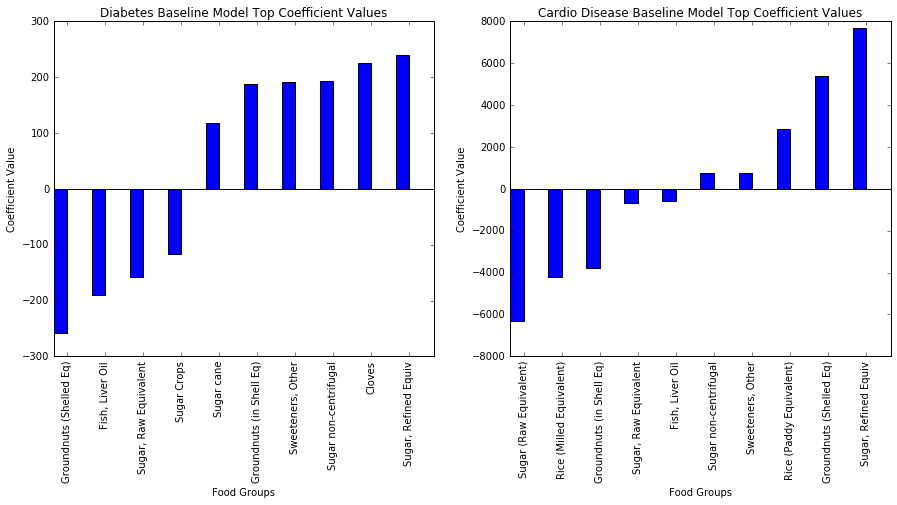

In [39]:
# Graph baseline model diabetes and cardio disease coefficients
graphCoefs(orders, ["Diabetes Baseline Model Top Coefficient Values", "Cardio Disease Baseline Model Top Coefficient Values"])

When we look at the top 10 predictors for diabetes and heart disease mortality, we see foods that background knowledge tells us is strongly associated with those illnesses (sugar, rice, and groundnuts). However, similar food groups have large coefficients but opposite sides, namely Sugar (Raw Equivalent) and Sugar, Refined Equivalent. Although this would imply that sugar both strongly increases and decreases diabetes/heart disease mortality rate, we should recall the meaning of the regression coefficient: it is associated with a change in Y, **holding all other Xs constant**. Given the nature of food and cooking, many meals contain ingredients which would fall into multiple food groups, making increasing consumption of one food while holding other constant difficult in reality. This is seen in the slight correlation of foods in the heat map above: not large enough to invalidate the model, but large enough to cloud the interpretation of coefficients. As a result, it is more important to consider the magnitude of the coefficients and the kinds of food groups with the largest coefficients than the coefficients' signs. Thus, we modify our graphCoefs function to instead plot the largest coefficients in order of their respective magnitudes.

In [40]:
# Create a bar chart with ordered coefficient magnitudes and their corresponding features
def graphCoefs(orders, name):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i in range(2):
        names, values, _ = orders[i]
        values = np.absolute(values)[::-1]
        names = names[::-1]
    
        N = len(names)
        ind = np.arange(N)    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence
        p = ax[i].bar(ind, values, width, color='b')

        # add some text for labels, title
        ax[i].set_xlabel('Food Groups')
        ax[i].set_ylabel('Coefficient Value')
        ax[i].set_title(name[i])
        ax[i].set_xticks(ind + width)
        ax[i].set_xticklabels(tuple(names), rotation='vertical')
        ax[i].set_xlim([0,N])

    plt.show()

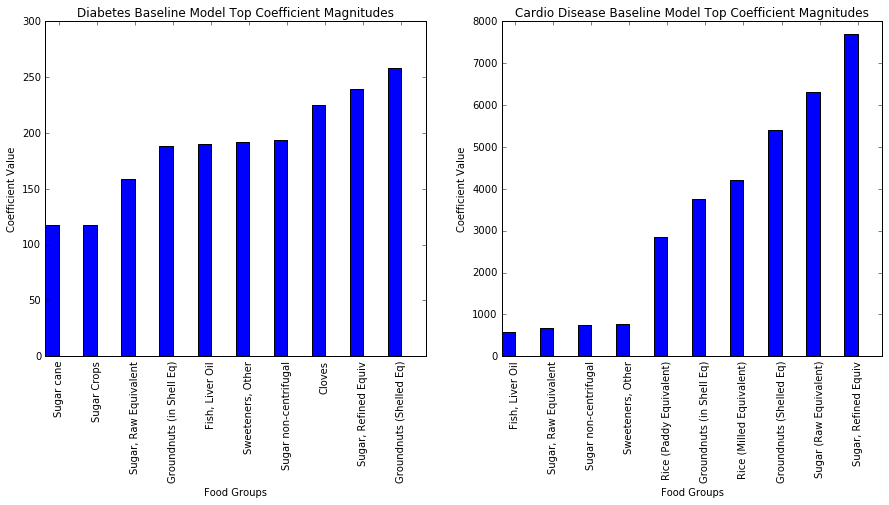

In [41]:
# Graph baseline model diabetes and cardio disease coefficient magnitudes
graphCoefs(magnitudes, ["Diabetes Baseline Model Top Coefficient Magnitudes", "Cardio Disease Baseline Model Top Coefficient Magnitudes"])

Unsurprisingly, sugars account for 7 of the top 10 predictors for diabetes mortality. The remaining 3, cloves, fish oil, and groundnuts have been shown to reduce glucose levels, and help mitigate diabetes risk. Similarly, foods high in refined sugars and carbohydrates, e.g. sugars/sweeteners and paddy (white) rice, are bad for heart health and thus appear in 6 of the top 10 most important predictors for heart disease mortality. Groundnuts and milled rice by contrast reduce blood pressure and are better for heart health.

To improve upon the baseline model, we should first consider the years worth of consumption data we have. We could experiment with both how large of a time delay between the measurement of the Xs (consumption data) and the Ys (disease data) and how many years of consumption data should be used to see what results in the best model overall.

Secondly, while our baseline models used all features when they were trained, we should try to prevent overfitting by excluding features that end up being unnecessary, cutting them out via forward/backwards subset construction or LASSO regularization.

Finally, we should be careful using our model to make predictions of health outcomes given consumption of a food. First, our model doesn’t take other features which affect personal health, such as healthcare spending and lifestyle, into account. Second, our model works with country data, even if a country has high consumption of a food and high incidence of a disease, that doesn’t necessarily imply that an individual who consumes little of it is less likely to have that disease.

We will first simultaneously consider how large of a time lag and how wide of a time interval is best for modeling a particular disease. Since a large amount of code could be used, it will be simpler to create a function. The function bestyears() first takes a dataframe of disease data and the year which is being tested. Then, for every possible interval between 1993 (the most recent year where country formed out of the fall of the USSR started reporting data) and the year of the disease data's collection, it runs 10-Fold cross validation to find the Mean Square Error of the model using that interval/lag. Ultimately, the function will print out the best lag and interval length and return the best range of years.

In [42]:
def bestyears(disease,disease_year):
    min_MSE = 1e10 # set some initial small value for min MSE
    # initialize best features
    best_lag = 0
    best_int = 0
    best_end = 0
    best_start = 0
    # try a year
    for endyear in range(1993,disease_year):
        # try all possible intervals from that 1993 to that year
        for startyear in range(1993,endyear+1):
            yearrange=range(startyear,endyear+1)
            dinner = dinnerint(yearrange)
            # return overlapping Xs and Ys
            foodOverlap, mortality = xyreturner(dinner,disease,disease_year)
            # prepare for CV, initialize list of BICs
            scores=[]
            k=len(foodOverlap)/10
            # split train-test data into k-1:1 folds, find the average BIC when doing CV
            for i in range(0,10):
                # Fit and evaluate BIC
                foodtrain=pd.concat([foodOverlap.iloc[:i*k],foodOverlap.iloc[(i+1)*k:]],axis=0)
                morttrain=pd.concat([mortality.iloc[:i*k],mortality.iloc[(i+1)*k:]],axis=0)
                model=LinReg()              
                model.fit(foodtrain,morttrain)
                y_pred = model.predict(foodOverlap.iloc[i*k:(i+1)*k])
                # add to list of BICs
                scores += [np.square(mortality.iloc[i*k:(i+1)*k] - y_pred)]
            # update if we did better
            MSE=np.mean(scores)
            if(MSE < min_MSE):
                best_lag=disease_year-endyear
                best_int=len(yearrange)
                min_MSE=MSE
                best_end = endyear
                best_start = startyear
                
    print "Best Lag:", best_lag
    print "Best Interval:", best_int
    print "Best End year:", best_end
    print "Best Start year:", best_start  
    print "Best MSE:", min_MSE
    # return final range
    return range(best_start, best_end+1)

Now that we have a method of getting the best year range, we can create another function to forward select the best predictors, adding the predictor that results in the largest increase in $R^2$ and stopping if the model's BIC goes up as a result, meaning that the increased accuracy isn't worth the increased complexity.

In [43]:
def forwardselector(disease,disease_year,yearrange):
    x = dinnerint(yearrange)
    d = x.shape[1] # total no. of predictors
    # find overlapping countries        
    Dc=list(set(disease['Country']))
    Fc=x.index.values        
    overlap=[]
    for country in Fc:
        if country in Dc:
            overlap.append(country)
    x = x.ix[overlap]
    # return ys of overlapping countries
    diabOverlap = disease[disease["Country"].isin(overlap)]
    diabOverlap = diabOverlap[diabOverlap["Year"] == disease_year]
    if disease.equals(diabdata) or disease.equals(cardiodata):    
        # use disease data
        diabOverlap = diabOverlap[diabOverlap["Year"] == disease_year]        
        y = pd.Series(np.around(list(diabOverlap[" Both sexes"]), decimals=1),
                              index=x.index)
    else:
        print ("Error: Disease dataframe not recognized")
    # Keep track of current set of chosen predictors, and the remaining set of predictors
    current_predictors = [] 
    remaining_predictors = range(d)

    # Set some initial large value for min BIC score for all possible subsets
    global_min_bic = 1e10 

    # Keep track of the best subset of predictors
    best_subset = [] 

    # Iterate over all possible subset sizes, 0 predictors to d predictors
    for size in range(d):    
        max_r_squared = -1e10 # set some initial small value for max R^2
        best_predictor = -1 # set some throwaway initial number for the best predictor to add
        bic_with_best_predictor = 1e10 # set some initial large value for BIC score   

        # Iterate over all remaining predictors to find best predictor to add
        for i in remaining_predictors:
            # Make copy of current set of predictors
            temp = current_predictors[:]
            # Add predictor 'i'
            temp.append(i)
            
            # Use only a subset of predictors in the training data
            colsub=[x.columns.values[i] for i in temp]
            x_subset = x[colsub]

            # Fit and evaluate R^2
            model = OLS(y, x_subset)
            results = model.fit()
            r_squared = results.rsquared

            # Check if we get a higher R^2 value than than current max R^2, if so, update
            if(r_squared > max_r_squared):
                max_r_squared = r_squared
                best_predictor = i
                bic_with_best_predictor = results.bic

        # Remove best predictor from remaining list, and add best predictor to current list
        remaining_predictors.remove(best_predictor)
        current_predictors.append(best_predictor)

        # Check if BIC for with the predictor we just added is lower than 
        # the global minimum across all subset of predictors
        if(bic_with_best_predictor < global_min_bic):
            best_subset = current_predictors[:]
            global_min_bic = bic_with_best_predictor
    return best_subset

We can also use LASSO regression find the best subset, given a year range. LASSOselector first looks for the best lambda (from a list of powers from $10^{-7}$ to $10^7$) by running 10-fold cross validation on consumption and disease data from the inputted year, training on 9 of the folds and testing on the remaining one. The lambda that results in the lowest MSE is then used in a model fit on all of the data of the given year, and LASSOselector returns the nonzero coefficients and the aforementioned lambda.

In [49]:
def LASSOselector(disease,disease_year,yearrange):
    min_MSE = 1e10 # set some initial large value for min MSE score
    # initialize best features
    best_l = 0
    
    # load in data
    dinner=dinnerint(yearrange)
    foodOverlap, mortality = xyreturner(dinner,disease,disease_year)
    
    # initialize list of powers
    powers=map(lambda x: np.power(10.0,(float(x)-7.0)),range(15))
    for l in powers:
        # initialize list to hold MSE of folds
        scores=[]
        k=len(foodOverlap)/10
        # split train-test data into k-1:1 folds, find the average BIC when doing CV
        for i in range(0,10):
            # slice training data
            foodtrain=pd.concat([foodOverlap.iloc[:i*k],foodOverlap.iloc[(i+1)*k:]],axis=0)
            morttrain=pd.concat([mortality.iloc[:i*k],mortality.iloc[(i+1)*k:]],axis=0)
            # Lasso regression
            reg = Lasso_Reg(alpha = l)
            reg.fit(foodtrain, morttrain)
            # get predicted value and MSE
            ypred=reg.predict(foodOverlap.iloc[i*k:(i+1)*k])
            SE=np.square(ypred-mortality.iloc[i*k:(i+1)*k])
            # hold squared error
            scores.append(SE)
        MSE=np.mean(scores)
        #update best lambda if MSE is better than min_MSE:
        if MSE < min_MSE:
            best_l = l
            min_MSE = MSE
    
    # now that we have best_l, lets actually run LASSO to get final important predictors
    reg = Lasso_Reg(alpha = best_l)
    reg.fit(foodOverlap, mortality)
    coefficients = reg.coef_
    nonzero = [i for i, item in enumerate(coefficients) if abs(item) > 0]
    return nonzero, best_l

We can now find the best years for the 2000 diabetes data, and train forward selecting and LASSO linear regression models to that data. Afterwards, we can shift the best years up 12 years to test these models on the 2012 disease data.

In [50]:
# find best years and features for diabetes
diabyears=bestyears(diabdata,2000)
diabX=forwardselector(diabdata, 2000, diabyears)
print "Best Forward Selector Predictors by Index", diabX
_ , diab_l = LASSOselector(diabdata,2000,diabyears)
print "Best Lambda value for Lasso Regression:", diab_l

Best Lag: 3
Best Interval: 1
Best End year: 1997
Best Start year: 1997
Best MSE: 6190.03917233
Best Year Range: [1997]
Best Forward Selector Predictors by Index [9, 50, 49, 44, 35, 118, 84, 100, 83, 65, 45, 72, 81, 69, 77, 111]
Best Lambda value for Lasso Regression: 10.0


In [51]:
# load in data
dinner=dinnerint(diabyears)
features=[dinner.columns.values[i] for i in diabX]
dinnerfor=dinner[features]

# make and fit forward and Lasso models
x, y = xyreturner(dinnerfor,diabdata,2000)
diabfor=LinReg()
diabfor.fit(x,y)

x, y = xyreturner(dinner,diabdata,2000)
diablas=Lasso_Reg(alpha = diab_l)
diablas.fit(x,y)

# now we run this model on the 2012 data
diab12=[ele+12 for ele in diabyears] # shift the best int forward 12 years
dinner12=dinnerint(diab12)
x12, y12 = xyreturner(dinner12,diabdata,2012)
# Remove columns in test dataset that aren't in training set
extraCols = set(x12.columns.values.tolist()) - set(x.columns.values.tolist())
for col in extraCols:
    del x12[col]

# out put score
print "LASSO LinReg Score on 2012 Diabetes Data:",np.around(diablas.score(x12,y12),decimals=2)

din12for=dinner12[features]
x12, y12 = xyreturner(din12for,diabdata,2012)
print "Forward LinReg Score on 2012 Diabetes Data:",np.around(diabfor.score(x12,y12),decimals=2)

LASSO LinReg Score on 2012 Diabetes Data: 0.43
Forward LinReg Score on 2012 Diabetes Data: 0.38


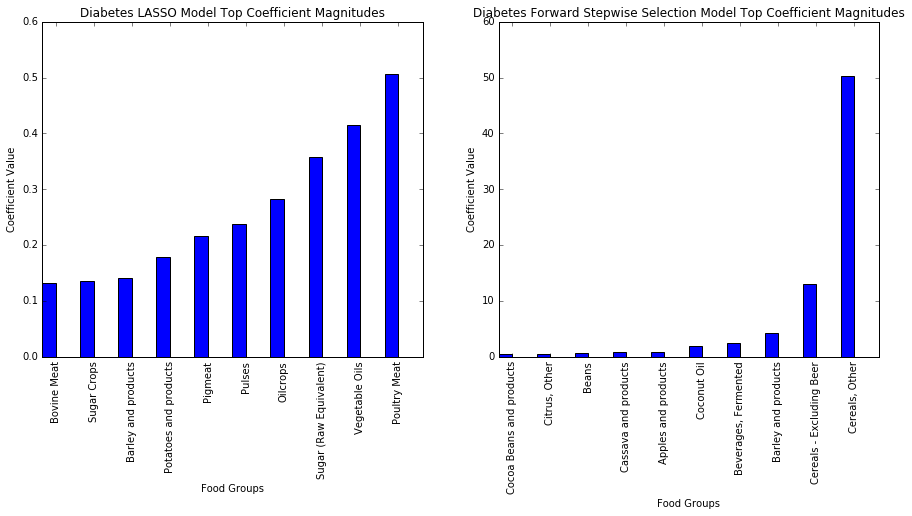

In [52]:
# Graph LASSO model and forward stepwise selection diabetes coefficient magnitudes
graphCoefs([topMagnitude(diablas, x, 10),topMagnitude(diabfor, x, 10)], ["Diabetes LASSO Model Top Coefficient Magnitudes","Diabetes Forward Stepwise Selection Model Top Coefficient Magnitudes"])

LASSO and forward selection have very different top 10 predictors. Although LASSO regularizes out foods which are correlated with each other - particularly processed foods such as the many kinds of sugar - sugar still appears twice, highlighting its importance as a predictor, and carbohydrates reappear in potatoes and barley products. Moreover, meat products are introduced as important predictors. Since a person can only eat so much meat, eating one kind decreases consumption of another. As a result, increased consumption leaner meats, such as poultry, causes people to eat less of fattier ones such as pigmeat (and bovine meat to a lesser extent) which are worse for diabetes risk. 

The size of the coefficients from forward selection drop rapidly, and the largest two are several times larger than the bottom 8: we should focus our analysis on them. Unsurprisingly, the top 2 predictors are cereals, high in carbohydrates and thus bad for diabetes risk. Additionally, the next two, while significantly smaller, are barley and fermented beverages which are also high in carbohydrates.

Since LASSO regression has a higher $R^2$ value, we can say that it's a better model and feel more strongly about its predictors' relationships with diabetes.

We now fit and score models on our cardio disease data in a similar fashion to our approach with the diabetes data, graphing the coefficients with the largest magnitudes at the end.

In [53]:
# find best years and features for heart disease
cardyears=bestyears(cardiodata,2000)
cardX=forwardselector(cardiodata, 2000, cardyears)
print "Best Forward Selector Predictors by Index", cardX
_ , card_l=LASSOselector(cardiodata,2000,cardyears)
print "Best Lambda value for Lasso Regression:", card_l

Best Lag: 5
Best Interval: 1
Best End year: 1995
Best Start year: 1995
Best MSE: 176090.789907
Best Forward Selector Predictors by Index [9, 66, 86, 96, 111, 41, 43, 113]
Best Lambda value for Lasso Regression: 100.0


In [54]:
# load in data
dinner=dinnerint(cardyears)
features=[dinner.columns.values[i] for i in cardX]
dinnerfor=dinner[features]
# make and fit forward and Lasso models
x, y = xyreturner(dinnerfor,cardiodata,2000)
cardfor=LinReg()
cardfor.fit(x,y)
x, y = xyreturner(dinner,cardiodata,2000)
cardlas=Lasso_Reg(alpha = card_l)
cardlas.fit(x,y)
# now we run this model on the 2012 data
card12=[ele+12 for ele in cardyears] # shift the best int forward 12 years
dinner12=dinnerint(card12)
x12, y12 = xyreturner(dinner12,cardiodata,2012)
# Remove columns in test dataset that aren't in training set
extraCols = set(x12.columns.values.tolist()) - set(x.columns.values.tolist())
for col in extraCols:
    del x12[col]
# out put score
print "LASSO LinReg Score on 2012 Heart Disease Data:",np.around(cardlas.score(x12,y12),decimals=2)
din12for=dinner12[features]
x12, y12 = xyreturner(din12for,cardiodata,2012)
print "Forward LinReg Score on 2012 Heart Disease Data:",np.around(cardfor.score(x12,y12),decimals=2)

LASSO LinReg Score on 2012 Heart Disease Data: 0.47
Forward LinReg Score on 2012 Heart Disease Data: 0.41


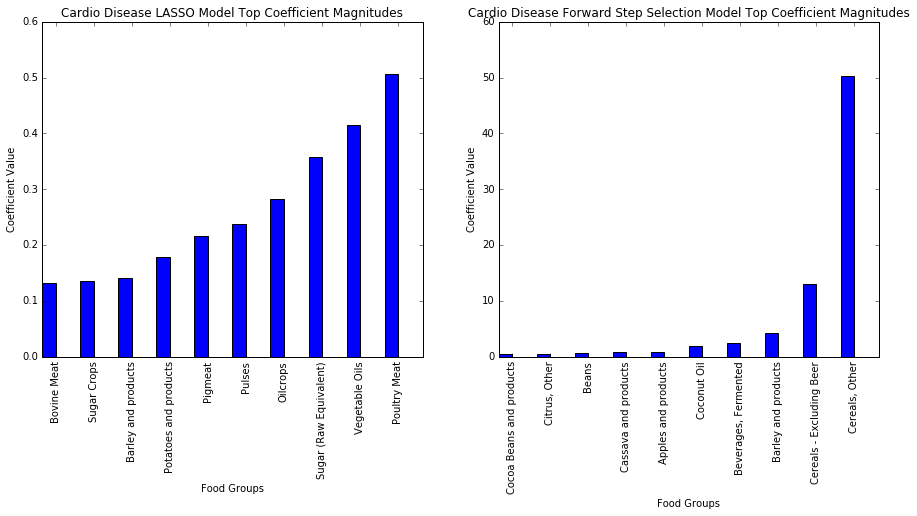

In [55]:
# Graph LASSO model and forward stepwise selection cardio disease coefficient magnitudes
graphCoefs([topMagnitude(diablas, x, 10),topMagnitude(diabfor, x, 10)], ["Cardio Disease LASSO Model Top Coefficient Magnitudes","Cardio Disease Forward Step Selection Model Top Coefficient Magnitudes"])

Similar to above, LASSO and forward selection result in very different top 10 predictors. LASSO regularization again shrinks all coefficients down to small numers, and zeros out repeats, but carbohydrates and sugars such as those seen in cereal, wheat, sugars, and alcoholic beverages are bad for heart health and account for 7 of the top 10. Milk and whole milk account for two the predictors: although it can be good for you, milk, especially whole milk, contains cholesterol which is bad in excess. Finally, while mandrine oranges contain vital nutrients, their place at the top should not be overstated: it's coefficient is still barely above one.

While the exponential growth of coefficient magnitude is present in forward selection, the top 4 predictors are all once again high in carbohydrates - 3 of which are explicitly alcohol products - which when consumed in excess are associated with poor heart health.

Again, the LASSO model has a slightly higher $R^2$, suggesting that it fits the data better than the forward stepwise selection model. 

In the cases of diabetes and heart disease, regardless of whether we used LASSO or forward selection, our models consistently returned $R^2$ values of ~0.4. While this is better than our baseline and null models, these results suggest that diet plays an important, but not overwhelming role in mortality rate. It is likely, then, that other factors such as body weight, fitness level and income/healthcare also play a role in the mortality rates of these diseases.